In [ ]:
!pip install einops

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary



from torchvision import models
import torch.nn as nn

import numpy as np
from tqdm import tqdm_notebook as tqdm
import cv2
from sklearn import metrics
from sklearn.metrics import jaccard_score as js
from PIL import Image, ImageOps
from torch.autograd import Variable as v
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import pickle

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
def randomHueSaturationValue(image, hue_shift_limit=(-180, 180),
                             sat_shift_limit=(-255, 255),
                             val_shift_limit=(-255, 255), u=0.5):
    if np.random.random() < u:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(image)
        hue_shift = np.random.randint(hue_shift_limit[0], hue_shift_limit[1]+1)
        hue_shift = np.uint8(hue_shift)
        h += hue_shift
        sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
        s = cv2.add(s, sat_shift)
        val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
        v = cv2.add(v, val_shift)
        image = cv2.merge((h, s, v))
        #image = cv2.merge((s, v))
        image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
    return image

def randomShiftScaleRotate(image, mask,
                           shift_limit=(-0.0, 0.0),
                           scale_limit=(-0.0, 0.0),
                           rotate_limit=(-0.0, 0.0),
                           aspect_limit=(-0.0, 0.0),
                           borderMode=cv2.BORDER_CONSTANT, u=0.5):
    if np.random.random() < u:
        height, width, channel = image.shape
        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)
        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])
        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])
        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags = cv2.INTER_LINEAR, borderMode = borderMode,borderValue = (0, 0,0,))
        mask = cv2.warpPerspective(mask, mat, (width, height), flags = cv2.INTER_LINEAR, borderMode = borderMode, borderValue = (0, 0,0,))
    return image, mask

def randomFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)
    return image, mask

#def randomRotate90
#def randomMove

def randomRotate90(image, mask, u=0.5):
    if np.random.random() < u:
        image=np.rot90(image)
        mask=np.rot90(mask)
    return image, mask

def loader(img_path, mask_path, phase):
    #print('image: ', img_path)
    #print('mask: ', mask_path)

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  #, cv2.IMREAD_GRAYSCALE

    #print(img_path)
    #print(img.shape)
    #print(mask.shape)

    img = cv2.resize(img, (256,256),cv2.INTER_AREA)
    mask = cv2.resize(mask, (256,256),cv2.INTER_AREA)

    #img=Image.open(img_path)
    #img=img.resize((256,256), Image.ANTIALIAS)
    #mask=Image.open(mask_path)
    #mask=mask.resize((256,256), Image.ANTIALIAS)

    #if(phase == 'train'):
    #    img = randomHueSaturationValue(img,
    #                                  hue_shift_limit=(-30, 30),
    #                                  sat_shift_limit=(-5, 5),
    #                                  val_shift_limit=(-15, 15)
    #                                  )

    #    img, mask = randomShiftScaleRotate(img, mask,
    #                                      shift_limit=(-0.1, 0.1),
    #                                      scale_limit=(-0.1, 0.1),
    #                                      aspect_limit=(-0.1, 0.1),
    #                                      rotate_limit=(-0, 0))
    #    img, mask = randomFlip(img, mask)
    #    img, mask = randomRotate90(img, mask)

    img = np.array(img, np.float32).transpose(2,0,1)/255.0
    mask = np.array(mask, np.float32)
    mask = mask[np.newaxis,:,:]
    #print(mask.sum())
    mask = mask/255.0
    mask[mask >= 0.5] = 1
    mask[mask < 0.5] = 0
    #mask = 1 - mask
    #mask = mask[0, :, :, :]
    #print(mask[:, :, 0].shape)
    #t_mask = np.array([mask[:, :, 0], mask[:, :, 1], mask[:, :, 2]])


    #mask = t_mask
    #print(mask.shape, img.shape)
    return img, mask

def read_dataset(root_path, mode):
  images = []
  masks = []

  if(mode == 'Train'):
    image_root = os.path.join(root_path, 'Train/images')
    gt_root = os.path.join(root_path, 'Train/mask')
  else :
    image_root = os.path.join(root_path, 'Train/images')
    gt_root = os.path.join(root_path, 'Train/mask')

  #print(os.listdir(image_root))
  #print(os.listdir(gt_root))
  for image_name in sorted(os.listdir(image_root)):
    image_path = os.path.join(image_root, image_name) #.split('.')[0] + '.jpg')
    images.append(image_path)
  for mask_name in sorted(os.listdir(gt_root)):
    label_path = os.path.join(gt_root, mask_name) #.split('.')[0] + '.tif')
    masks.append(label_path)

    # print(images, masks)
    #images.sort()
    #masks.sort()
  return images, masks

class Eye_Dataset(Dataset):

    def __init__(self, root_path, phase):
        self.root = root_path
        self.phase = phase
        self.images, self.labels = read_dataset(self.root, self.phase)
        print('images: ', self.images)
        print('labels: ', self.labels)

    def __getitem__(self, index):

        img, mask = loader(self.images[index], self.labels[index], self.phase)
        img = torch.tensor(img, dtype = torch.float32)
        mask = torch.tensor(mask, dtype = torch.float32)
        return img, mask

    def __len__(self):
        assert len(self.images) == len(self.labels), 'The number of images must be equal to labels'
        return len(self.images)

In [ ]:
import torch
import torch.nn as nn


class FixedPositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_length=5000):
        super(FixedPositionalEncoding, self).__init__()

        pe = torch.zeros(max_length, embedding_dim)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embedding_dim, 2).float()
            * (-torch.log(torch.tensor(10000.0)) / embedding_dim)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return x


class LearnedPositionalEncoding(nn.Module):
    def __init__(self, max_position_embeddings, embedding_dim, seq_length):
        super(LearnedPositionalEncoding, self).__init__()
        self.pe = nn.Embedding(max_position_embeddings, embedding_dim)
        self.seq_length = seq_length

        self.register_buffer(
            "position_ids",
            torch.arange(max_position_embeddings).expand((1, -1)),
        )

    def forward(self, x, position_ids=None):
        if position_ids is None:
            position_ids = self.position_ids[:, : self.seq_length]

        position_embeddings = self.pe(position_ids)
        return x + position_embeddings

In [ ]:
class IntermediateSequential(nn.Sequential):
    def __init__(self, *args, return_intermediate=True):
        super().__init__(*args)
        self.return_intermediate = return_intermediate

    def forward(self, input):
        if not self.return_intermediate:
            return super().forward(input)

        intermediate_outputs = {}
        output = input
        for name, module in self.named_children():
            output = intermediate_outputs[name] = module(output)

        return output, intermediate_outputs

In [ ]:
class SelfAttention(nn.Module):
    def __init__(
        self, dim, heads=8, qkv_bias=False, qk_scale=None, dropout_rate=0.0
    ):
        super().__init__()
        self.num_heads = heads
        head_dim = dim // heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(dropout_rate)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout_rate)

    def forward(self, x):
        B, N, C = x.shape
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.num_heads, C // self.num_heads)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )  # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x):
        return self.fn(self.norm(x))


class PreNormDrop(nn.Module):
    def __init__(self, dim, dropout_rate, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fn = fn

    def forward(self, x):
        return self.dropout(self.fn(self.norm(x)))


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout_rate):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(p=dropout_rate),
        )

    def forward(self, x):
        return self.net(x)


class TransformerModel(nn.Module):
    def __init__(
        self,
        dim,
        depth,
        heads,
        mlp_dim,
        dropout_rate=0.1,
        attn_dropout_rate=0.1,
    ):
        super().__init__()
        layers = []
        for _ in range(depth):
            layers.extend(
                [
                    Residual(
                        PreNormDrop(
                            dim,
                            dropout_rate,
                            SelfAttention(
                                dim, heads=heads, dropout_rate=attn_dropout_rate
                            ),
                        )
                    ),
                    Residual(
                        PreNorm(dim, FeedForward(dim, mlp_dim, dropout_rate))
                    ),
                ]
            )
        self.net = IntermediateSequential(*layers)

    def forward(self, x):
        return self.net(x)

In [ ]:
class SegmentationTransformer(nn.Module):
    def __init__(
        self,
        img_dim,
        patch_dim,
        num_channels,
        embedding_dim,
        num_heads,
        num_layers,
        hidden_dim,
        dropout_rate=0.0,
        attn_dropout_rate=0.0,
        conv_patch_representation=False,
        positional_encoding_type="learned",
    ):
        super(SegmentationTransformer, self).__init__()

        assert embedding_dim % num_heads == 0
        assert img_dim % patch_dim == 0

        self.img_dim = img_dim
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.patch_dim = patch_dim
        self.num_channels = num_channels
        self.dropout_rate = dropout_rate
        self.attn_dropout_rate = attn_dropout_rate
        self.conv_patch_representation = conv_patch_representation

        self.num_patches = int((img_dim // patch_dim) ** 2)
        self.seq_length = self.num_patches
        self.flatten_dim = patch_dim * patch_dim * num_channels

        self.linear_encoding = nn.Linear(self.flatten_dim, embedding_dim)
        if positional_encoding_type == "learned":
            self.position_encoding = LearnedPositionalEncoding(
                self.seq_length, self.embedding_dim, self.seq_length
            )
        elif positional_encoding_type == "fixed":
            self.position_encoding = FixedPositionalEncoding(
                self.embedding_dim,
            )

        self.pe_dropout = nn.Dropout(p=self.dropout_rate)

        self.transformer = TransformerModel(
            embedding_dim,
            num_layers,
            num_heads,
            hidden_dim,
            self.dropout_rate,
            self.attn_dropout_rate,
        )
        self.pre_head_ln = nn.LayerNorm(embedding_dim)

        if self.conv_patch_representation:
            self.conv_x = nn.Conv2d(
                self.num_channels,
                self.embedding_dim,
                kernel_size=(self.patch_dim, self.patch_dim),
                stride=(self.patch_dim, self.patch_dim),
                padding=self._get_padding(
                    'VALID', (self.patch_dim, self.patch_dim),
                ),
            )
        else:
            self.conv_x = None

    def _init_decode(self):
        raise NotImplementedError("Should be implemented in child class!!")

    def encode(self, x):
        n, c, h, w = x.shape
        if self.conv_patch_representation:
            # combine embedding w/ conv patch distribution
            x = self.conv_x(x)
            x = x.permute(0, 2, 3, 1).contiguous()
            x = x.view(x.size(0), -1, self.embedding_dim)
        else:
            x = (
                x.unfold(2, self.patch_dim, self.patch_dim)
                .unfold(3, self.patch_dim, self.patch_dim)
                .contiguous()
            )
            x = x.view(n, c, -1, self.patch_dim ** 2)
            x = x.permute(0, 2, 3, 1).contiguous()
            x = x.view(x.size(0), -1, self.flatten_dim)
            x = self.linear_encoding(x)

        x = self.position_encoding(x)
        x = self.pe_dropout(x)

        # apply transformer
        x, intmd_x = self.transformer(x)
        x = self.pre_head_ln(x)

        return x, intmd_x

    def decode(self, x):
        raise NotImplementedError("Should be implemented in child class!!")

    def forward(self, x, auxillary_output_layers=None):
        encoder_output, intmd_encoder_outputs = self.encode(x)
        decoder_output = self.decode(
            encoder_output, intmd_encoder_outputs, auxillary_output_layers
        )

        if auxillary_output_layers is not None:
            auxillary_outputs = {}
            for i in auxillary_output_layers:
                val = str(2 * i - 1)
                _key = 'Z' + str(i)
                auxillary_outputs[_key] = intmd_encoder_outputs[val]

            return decoder_output, auxillary_outputs

        return decoder_output

    def _get_padding(self, padding_type, kernel_size):
        assert padding_type in ['SAME', 'VALID']
        if padding_type == 'SAME':
            _list = [(k - 1) // 2 for k in kernel_size]
            return tuple(_list)
        return tuple(0 for _ in kernel_size)

    def _reshape_output(self, x):
        x = x.view(
            x.size(0),
            int(self.img_dim / self.patch_dim),
            int(self.img_dim / self.patch_dim),
            self.embedding_dim,
        )
        x = x.permute(0, 3, 1, 2).contiguous()
        return x

In [ ]:
class SegmentationTransformer(nn.Module):
    def __init__(
        self,
        img_dim,
        patch_dim,
        num_channels,
        embedding_dim,
        num_heads,
        num_layers,
        hidden_dim,
        dropout_rate=0.0,
        attn_dropout_rate=0.0,
        conv_patch_representation=False,
        positional_encoding_type="learned",
    ):
        super(SegmentationTransformer, self).__init__()

        assert embedding_dim % num_heads == 0
        assert img_dim % patch_dim == 0

        self.sig = nn.Sigmoid()

        self.img_dim = img_dim
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.patch_dim = patch_dim
        self.num_channels = num_channels
        self.dropout_rate = dropout_rate
        self.attn_dropout_rate = attn_dropout_rate
        self.conv_patch_representation = conv_patch_representation

        self.num_patches = int((img_dim // patch_dim) ** 2)
        self.seq_length = self.num_patches
        self.flatten_dim = patch_dim * patch_dim * num_channels

        self.linear_encoding = nn.Linear(self.flatten_dim, embedding_dim)
        if positional_encoding_type == "learned":
            self.position_encoding = LearnedPositionalEncoding(
                self.seq_length, self.embedding_dim, self.seq_length
            )
        elif positional_encoding_type == "fixed":
            self.position_encoding = FixedPositionalEncoding(
                self.embedding_dim,
            )

        self.pe_dropout = nn.Dropout(p=self.dropout_rate)

        self.transformer = TransformerModel(
            embedding_dim,
            num_layers,
            num_heads,
            hidden_dim,
            self.dropout_rate,
            self.attn_dropout_rate,
        )
        self.pre_head_ln = nn.LayerNorm(embedding_dim)

        if self.conv_patch_representation:
            self.conv_x = nn.Conv2d(
                self.num_channels,
                self.embedding_dim,
                kernel_size=(self.patch_dim, self.patch_dim),
                stride=(self.patch_dim, self.patch_dim),
                padding=self._get_padding(
                    'VALID', (self.patch_dim, self.patch_dim),
                ),
            )
        else:
            self.conv_x = None

    def _init_decode(self):
        raise NotImplementedError("Should be implemented in child class!!")

    def encode(self, x):
        n, c, h, w = x.shape
        if self.conv_patch_representation:
            # combine embedding w/ conv patch distribution
            x = self.conv_x(x)
            x = x.permute(0, 2, 3, 1).contiguous()
            x = x.view(x.size(0), -1, self.embedding_dim)
        else:
            x = (
                x.unfold(2, self.patch_dim, self.patch_dim)
                .unfold(3, self.patch_dim, self.patch_dim)
                .contiguous()
            )
            x = x.view(n, c, -1, self.patch_dim ** 2)
            x = x.permute(0, 2, 3, 1).contiguous()
            x = x.view(x.size(0), -1, self.flatten_dim)
            x = self.linear_encoding(x)

        x = self.position_encoding(x)
        x = self.pe_dropout(x)

        # apply transformer
        x, intmd_x = self.transformer(x)
        x = self.pre_head_ln(x)

        return x, intmd_x

    def decode(self, x):
        raise NotImplementedError("Should be implemented in child class!!")

    def forward(self, x, auxillary_output_layers=None):
        encoder_output, intmd_encoder_outputs = self.encode(x)
        decoder_output = self.decode(
            encoder_output, intmd_encoder_outputs, auxillary_output_layers
        )

        if auxillary_output_layers is not None:
            auxillary_outputs = {}
            for i in auxillary_output_layers:
                val = str(2 * i - 1)
                _key = 'Z' + str(i)
                auxillary_outputs[_key] = intmd_encoder_outputs[val]

            return decoder_output, auxillary_outputs

        return decoder_output

    def _get_padding(self, padding_type, kernel_size):
        assert padding_type in ['SAME', 'VALID']
        if padding_type == 'SAME':
            _list = [(k - 1) // 2 for k in kernel_size]
            return tuple(_list)
        return tuple(0 for _ in kernel_size)

    def _reshape_output(self, x):
        x = x.view(
            x.size(0),
            int(self.img_dim / self.patch_dim),
            int(self.img_dim / self.patch_dim),
            self.embedding_dim,
        )
        x = x.permute(0, 3, 1, 2).contiguous()
        return x


class SETR_Naive(SegmentationTransformer):
    def __init__(
        self,
        img_dim=256,
        patch_dim=16,
        num_channels=3,
        num_classes=1,
        embedding_dim=768,
        num_heads=8,
        num_layers=12,
        hidden_dim=3,
        dropout_rate=0.0,
        attn_dropout_rate=0.0,
        conv_patch_representation=False,
        positional_encoding_type="learned",
    ):
        super(SETR_Naive, self).__init__(
            img_dim=img_dim,
            patch_dim=patch_dim,
            num_channels=num_channels,
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            num_layers=num_layers,
            hidden_dim=hidden_dim,
            dropout_rate=dropout_rate,
            attn_dropout_rate=attn_dropout_rate,
            conv_patch_representation=conv_patch_representation,
            positional_encoding_type=positional_encoding_type,
        )

        self.num_classes = num_classes
        self._init_decode()

    def _init_decode(self):
        self.conv1 = nn.Conv2d(
            in_channels=self.embedding_dim,
            out_channels=self.embedding_dim,
            kernel_size=1,
            stride=1,
            padding=self._get_padding('VALID', (1, 1),),
        )
        self.bn1 = nn.BatchNorm2d(self.embedding_dim)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=self.embedding_dim,
            out_channels=self.num_classes,
            kernel_size=1,
            stride=1,
            padding=self._get_padding('VALID', (1, 1),),
        )
        self.upsample = nn.Upsample(
            scale_factor=self.patch_dim, mode='bilinear'
        )

    def forward(self, x, intmd_layers=None): #intmd_x,
        #print(x.shape)
        x = self._reshape_output(x)
        #print("yo",x.shape)
        x = self.conv1(x)
        #print("yoa",x.shape)
        x = self.bn1(x)
        #x = self.act1(x)
        #x = self.conv2(x)
        #print("yob",x.shape)
        #x = self.upsample(x)
        #print("yoc",x.shape)
        #x= self.sig(x)
        #print("yo2",x.shape)
        return x


In [ ]:
#RFB
class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()


        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)

        self.convx = nn.Conv2d(in_channels = 64 , out_channels = 256, kernel_size = 1)


    def forward(self, x):
        #print("x is",list(x.shape))
        x = self.conv(x)
        x = self.bn(x)
        return x
class BasicConv2d1(nn.Module): #this is a lil customized to balance the tensor of my previous work feel  free to make changes
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d1, self).__init__()


        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        self.convx = nn.Conv2d(in_channels = 32 , out_channels = 64, kernel_size = 1)


    def forward(self, x):
        #print("x is",list(x.shape))
        #x= self.convx(x)
        x = self.conv(x)
        x = self.bn(x)
        #x = self.convx(x)
        #print("x is",list(x.shape))
        return x
class RFB_modified(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(RFB_modified, self).__init__()
        self.relu = nn.ReLU(True)
        self.branch0 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
        )
        self.branch1 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 3), padding=(0, 1)),
            BasicConv2d(out_channel, out_channel, kernel_size=(3, 1), padding=(1, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=3, dilation=3)
        )
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 5), padding=(0, 2)),
            BasicConv2d(out_channel, out_channel, kernel_size=(5, 1), padding=(2, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=5, dilation=5)
        )
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(out_channel, out_channel, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=7, dilation=7)
        )
        self.conv_cat = BasicConv2d(4*out_channel, out_channel, 3, padding=1)
        self.conv_res = BasicConv2d1(in_channel, out_channel, 1)
        #self.convx = nn.Conv2d(in_channels = 6 , out_channels = 256, kernel_size = 1)
        #self.convx1 = nn.Conv2d(in_channels = 256 , out_channels = 64, kernel_size = 1)
    def forward(self, x):
      #print("fff",x.shape)
      x0 = self.branch0(x)
      x1 = self.branch1(x)
      x2 = self.branch2(x)
      x3 = self.branch3(x)
      x_cat = self.conv_cat(torch.cat((x0, x1, x2, x3), 1))
      #x_cat =self.convx(x_cat)
      #print("cat",x_cat.shape)
      x = self.relu(x_cat + self.conv_res(x))
      return x




In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class BatchNorm(nn.Module):
  def init(self, out_channels):
    super(BatchNorm, self).init()
    #self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()

  def forward(self, x):
    #x = self.conv(x)
    x = self.bn(x)
    x = self.relu(x)
    return x



In [ ]:
#just playing around a bit...don't mind me
class UTNet(nn.Module):
    def __init__(self, n_channels = 3, n_classes = 1, bilinear=False):
        super(UTNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        factor = 2 if bilinear else 1

        self.act = nn.Sigmoid()

        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024 // factor)

        self.up4 = Up(1024, 512 // factor, bilinear)
        self.up3 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128, bilinear)
        self.up1 = Up(128, 64, bilinear)

        self.inc = DoubleConv(3, 64)
        self.con1 = DoubleConv(128, 128)
        self.con2 = DoubleConv(256, 256)
        self.con3 = DoubleConv(512, 512)
        self.con4 = DoubleConv(1792, 1024)
        self.con5 = DoubleConv(512, 512)
        self.con6 = DoubleConv(256, 256)
        self.con7 = DoubleConv(128, 128)
        self.con8 = DoubleConv(64, 64)
        self.outconv = OutConv(64, 1)
        self.filter = OutConv(1,1)
        self.rectify = DoubleConv(768, 1024)

        self.rfb_u4 = RFB_modified(512, 512)
        self.rfb_u3 = RFB_modified(256, 256)
        self.rfb_u2 = RFB_modified(128, 128)
        self.rfb_u1 = RFB_modified(64, 64)

        self.tru = SETR_Naive()
        self.sig = nn.Sigmoid()

    def forward(self, x):


        x1 = self.inc(x)
        x1_s = x1

        x2 = self.down1(x1)
        x2 = self.con1(x2)
        x2_s = x2

        x3 = self.down2(x2)
        x3 = self.con2(x3)
        x3_s = x3

        x4 = self.down3(x3)
        x4 = self.con3(x4)
        x4_s = x4


        xb = self.down4(x4)
        xt = self.tru(x)
        #xt = self.rectify(xt)
        xb = torch.cat((xb, xt),1)
        xb = self.con4(xb)
        xb_s = xb


        y4 = self.up4(xb_s, x4_s)
        y4 = self.rfb_u4(y4)
        y4 = self.con5(y4)
        y4_s = y4

        y3 = self.up3(y4_s, x3_s)
        y3 = self.rfb_u3(y3)
        y3 = self.con6(y3)
        y3_s = y3

        y2 = self.up2(y3_s, x2_s)
        y2 = self.rfb_u2(y2)
        y2 = self.con7(y2)
        y2_s = y2

        y1 = self.up1(y2_s, x1_s)
        y1 = self.rfb_u1(y1)
        y1 = self.con8(y1)

        out = self.outconv(y1)
        #out = self.filter(out)
        out = self.act(out)

        return out

In [ ]:
root_path = '/content/drive/MyDrive/Datasets/CVC Clinicdb'
input_size = (3,256,256) #for kaggle 448
batch_size = 1
learning_rate = 0.0002
epochs = 300

INITAL_EPOCH_LOSS = 10000
NUM_EARLY_STOP = 20
NUM_UPDATE_LR = 8

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
def acc_sen_iou(pred, mask) :

    pred = torch.round(pred)
    #TP = (mask * pred).sum(1).sum(1).sum(1)
    TP = (mask * pred).sum()
    #TN = ((1 - mask) * (1 - pred)).sum(1).sum(1).sum(1)
    TN = ((1 - mask) * (1 - pred)).sum()
    #FP = pred.sum(1).sum(1).sum(1) - TP
    FP = pred.sum() - TP
    #FN = mask.sum(1).sum(1).sum(1) - TP
    FN = mask.sum() - TP
    acc = (TP + TN)/ (TP + TN + FP + FN)
    acc = torch.sum(acc)
    iou = (TP)/(TP + FN + FP)
    iou = torch.sum(iou)

    #iou = jsc(mask.cpu().numpy().reshape(-1), pred.cpu().numpy().reshape(-1))

    sen = TP / (TP + FN)
    sen = torch.sum(sen)
    return acc, sen, iou

def diceCoeff(pred, gt, smooth=1e-5, activation='none'):
    """ computational formula：
        dice = (2 * (pred ∩ gt)) / (pred ∪ gt)
    """

    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = nn.Softmax2d()
    else:
        raise NotImplementedError("Activation implemented for sigmoid and softmax2d activation function operation")

    pred = activation_fn(pred)

    N = gt.size(0)
    pred_flat = pred.view(N, -1)
    gt_flat = gt.view(N, -1)

    intersection = (pred_flat * gt_flat).sum(1)
    unionset = pred_flat.sum(1) + gt_flat.sum(1)
    loss = (2 * intersection + smooth) / (unionset + smooth)

    return loss.sum() / N

#calculation of precision and recall
def calc_prerec(mask, pred):
  pred = torch.round(pred)
  #TP = (mask * pred).sum(1).sum(1).sum(1)
  TP = (mask * pred).sum()
  #FP = pred.sum(1).sum(1).sum(1) - TP
  FP = pred.sum() - TP
  #FN = mask.sum(1).sum(1).sum(1) - TP
  FN = mask.sum() - TP
  prec = (TP)/ (TP + FP)
  prec = torch.sum(prec)
  recc = TP / (TP + FN)
  recc = torch.sum(recc)
  return prec, recc

#calculate DSC
def dice_score(mask,pred):
  pred = torch.round(pred)
  #TP = (mask * pred).sum(1).sum(1).sum(1)
  TP = (mask * pred).sum()
  #FP = pred.sum(1).sum(1).sum(1) - TP
  FP = pred.sum() - TP
  #FN = mask.sum(1).sum(1).sum(1) - TP
  FN = mask.sum() - TP
  dice=(2*TP)/(2*TP+FP+FN)
  dice=torch.sum(dice)
  return dice
'''
#calcuation of jaccard index between two random images
def dice_coef(img, img2):
        if img.shape != img2.shape:
            raise ValueError("Shape mismatch: img and img2 must have to be of the same shape.")
        else:

            lenIntersection=0

            for i in range(img.shape[0]):
                for j in range(img.shape[1]):
                    if ( np.array_equal(img[i][j],img2[i][j]) ):
                        lenIntersection+=1

            lenimg=img.shape[0]img.shape[1]
            lenimg2=img2.shape[0]img2.shape[1]
            value2 = (lenIntersection  / (lenimg + lenimg2 - lenIntersection))
        return value2
'''

'''
pred = (np.random.rand(1, 500,500))
mask = np.round_(np.random.randint(0,2,(1, 500,500)))
#print(.)
#print(mask)
a, s = acc_sen(torch.Tensor(pred), torch.Tensor(mask))
d = dice_score(torch.Tensor(mask), torch.Tensor(pred))
p, r = calc_prerec(torch.Tensor(mask), torch.Tensor(pred))
print(a, s)
print(d)
print(p, r)
print(pred)
print(mask)
'''

'\npred = (np.random.rand(1, 500,500))\nmask = np.round_(np.random.randint(0,2,(1, 500,500)))\n#print(.)\n#print(mask)\na, s = acc_sen(torch.Tensor(pred), torch.Tensor(mask))\nd = dice_score(torch.Tensor(mask), torch.Tensor(pred))\np, r = calc_prerec(torch.Tensor(mask), torch.Tensor(pred))\nprint(a, s)\nprint(d)\nprint(p, r)\nprint(pred)\nprint(mask)\n'

In [ ]:
class MyFrame():
    def __init__(self, net, learning_rate, device, evalmode=False):
      self.net = net().to(device)
      self.optimizer = torch.optim.Adam(params=self.net.parameters(), lr=learning_rate, weight_decay=0.0001)
      self.loss = horny_loss().to(device)
      self.lr = learning_rate

    def set_input(self, img_batch, mask_batch=None):
        self.img = img_batch
        self.mask = mask_batch

    def optimize(self):
      self.optimizer.zero_grad()
      pred = self.net.forward(self.img)
      #print(list(mask.shape),mask.dtype)
      #print(list(pred.shape),pred.dtype)
      loss = self.loss(self.mask, pred)
      loss.backward()
      self.optimizer.step()
      return loss, pred

    def save(self, path):
        torch.save(self.net.state_dict(), path)

    def load(self, path):
        self.net.load_state_dict(torch.load(path))

    def update_lr(self, new_lr, factor=False):

        if factor:
            new_lr = self.lr / new_lr
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = new_lr

        print ('update learning rate: %f -> %f' % (self.lr, new_lr))
        print ('update learning rate: %f -> %f' % (self.lr, new_lr))
        self.lr = new_lr

class horny_loss(nn.Module):
    def __init__(self, batch=True):
        super(horny_loss, self).__init__()
        self.batch = batch
        self.mae_loss = torch.nn.L1Loss()
        self.bce_loss = torch.nn.BCELoss()

    def soft_dice_coeff(self, y_true, y_pred):
        smooth = 0.0  # may change
        if self.batch:
            i = torch.sum(y_true)
            j = torch.sum(y_pred)
            intersection = torch.sum(y_true * y_pred)
        else:
            i = y_true.sum(1).sum(1).sum(1)
            j = y_pred.sum(1).sum(1).sum(1)
            intersection = (y_true * y_pred).sum(1).sum(1).sum(1)
        score = (2. * intersection + smooth) / (i + j + smooth)
        # score = (intersection + smooth) / (i + j - intersection + smooth)#iou
        return score.mean()

    def soft_dice_loss(self, y_true, y_pred):
        loss = 1 - self.soft_dice_coeff(y_true, y_pred)
        return loss

    def iou_loss(self, inputs, targets):
        smooth = 0.0
        #inputs = inputs.view(-1)
        #targets = targets.view(-1)

        intersection = (inputs * targets).sum(1).sum(1).sum(1)
        total = (inputs + targets).sum(1).sum(1).sum(1)
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return (1 - IoU.mean())

    def forward(self, y_true, y_pred):
        a = self.mae_loss(y_pred, y_true)
        b = self.soft_dice_loss(y_true, y_pred)
        c = self.bce_loss(y_pred, y_true)
        d = self.iou_loss(y_pred, y_true)
        loss = 0.15*a + 0.4*b  + 0.15*c + 0.3*d
        #loss = 0.5*b + 0.5*c
        return loss




In [ ]:
def visualise(Loss, Accuracy, Dice, IOU, Precision, Recall, EP):
    #plt.subplots(figsize=(20, 3))
    figure, axis = plt.subplots(2, 3, figsize=(30, 6))

    # For Loss Function
    axis[0, 0].plot(EP, Loss, color='purple')
    axis[0, 0].set_title("Loss Function")

    # For Accuracy Function
    axis[0, 1].plot(EP, Accuracy, color='black')
    axis[0, 1].set_title("Accuracy")

    # For Dice
    axis[0, 2].plot(EP, Dice, color='cyan')
    axis[0, 2].set_title("Dice")

    # For IOU
    axis[1, 0].plot(EP, IOU, color='red')
    axis[1, 0].set_title("IOU")

    # For Precision
    axis[1, 1].plot(EP, Precision, color='blue')
    axis[1, 1].set_title("Precision")

    # For Recall
    axis[1, 2].plot(EP, Recall, color='green')
    axis[1, 2].set_title("Recall")

    #plt.figure(figsize=(30, 2))

    plt.show()

In [ ]:
train_dataset = Eye_Dataset(root_path, 'Train')
train_loader = DataLoader(train_dataset, batch_size = 1, shuffle = True)

images:  ['/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/1.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/10.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/100.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/101.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/102.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/103.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/104.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/105.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/106.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/107.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/108.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/109.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/11.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/110.tif', '/content/drive/MyDrive/Data

In [ ]:
test_dataset = Eye_Dataset(root_path = root_path, phase = 'Test')
test_loader = DataLoader(test_dataset, batch_size =1, shuffle = False)

images:  ['/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/1.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/10.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/100.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/101.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/102.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/103.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/104.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/105.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/106.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/107.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/108.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/109.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/11.tif', '/content/drive/MyDrive/Datasets/CVC Clinicdb/Train/images/110.tif', '/content/drive/MyDrive/Data

Epoch 42/300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


train_loss: 0.47813756317719
train_accuracy: 0.9017415588155334
train_sensitivity: 0.6235452703014357
train_dice: 0.4849822907431406
train_precision 0.4868681801795608
train_recall 0.6235452703014357
IOU: 0.3565171091537368
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9122446919535543
Test Sensitivity :  0.6696340819418212
Test Pecision :  0.5198751596304086
Test Recall :  0.6696340819418212
Test loss :  0.4441436655792125
Test IOU :  0.39664909167167467
Test Dice :  0.5265170366336138
Train plots:


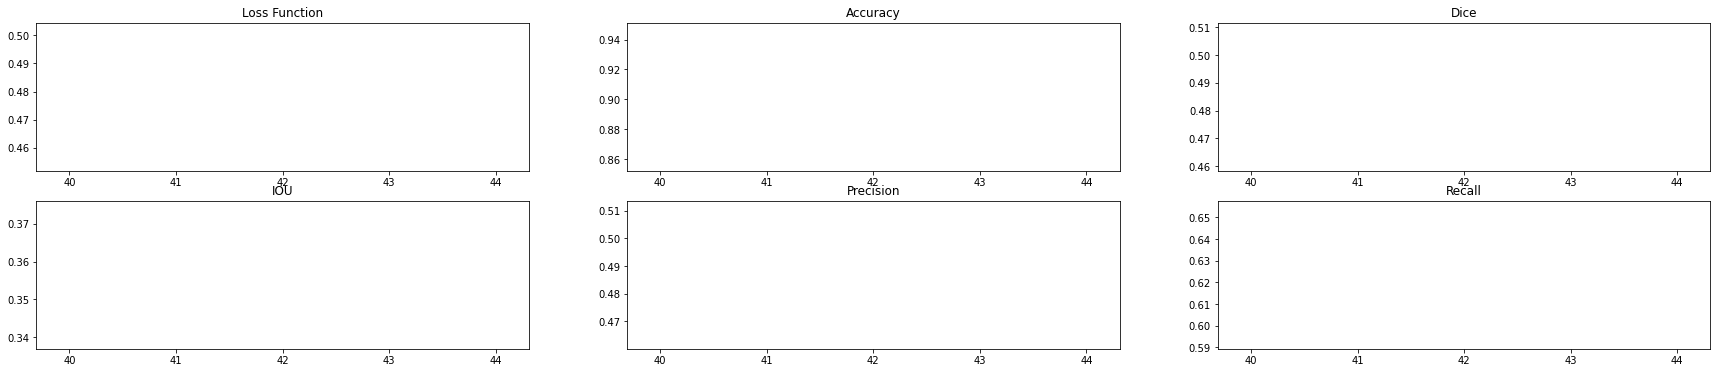

Test plots:


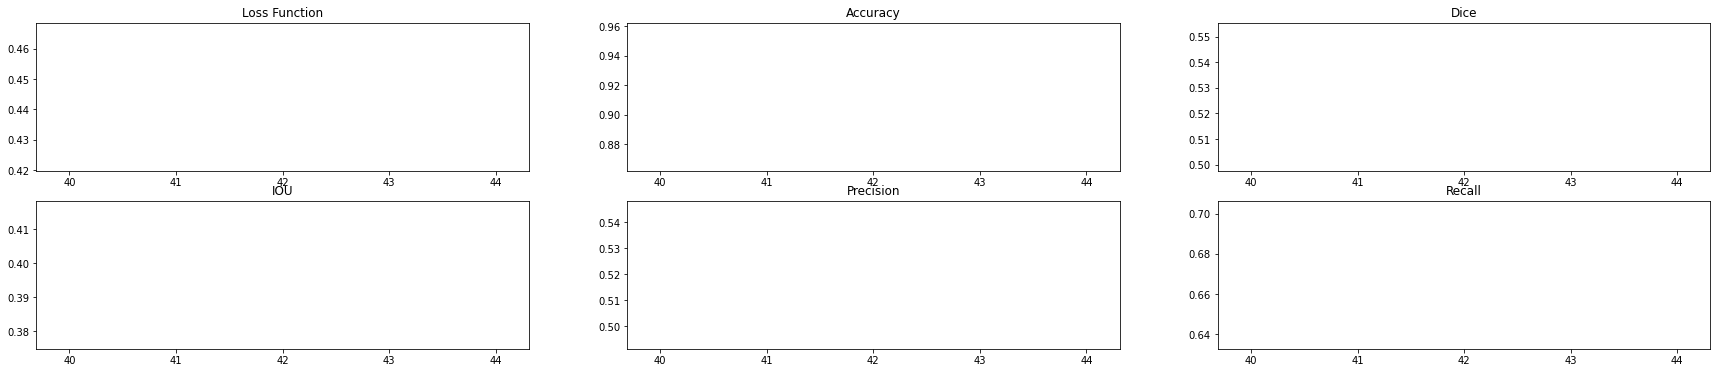

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 43/300


train_loss: 0.44228951298655605
train_accuracy: 0.9163209405137506
train_sensitivity: 0.6310796525283296
train_dice: 0.5271496643336155
train_precision 0.5493923015820013
train_recall 0.6310796525283296
IOU: 0.3972817291940593
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9281227195655907
Test Sensitivity :  0.6182640550774096
Test Pecision :  0.6158248286544185
Test Recall :  0.6182640550774096
Test loss :  0.411853999881954
Test IOU :  0.43343235896183896
Test Dice :  0.5657687903323889
Train plots:


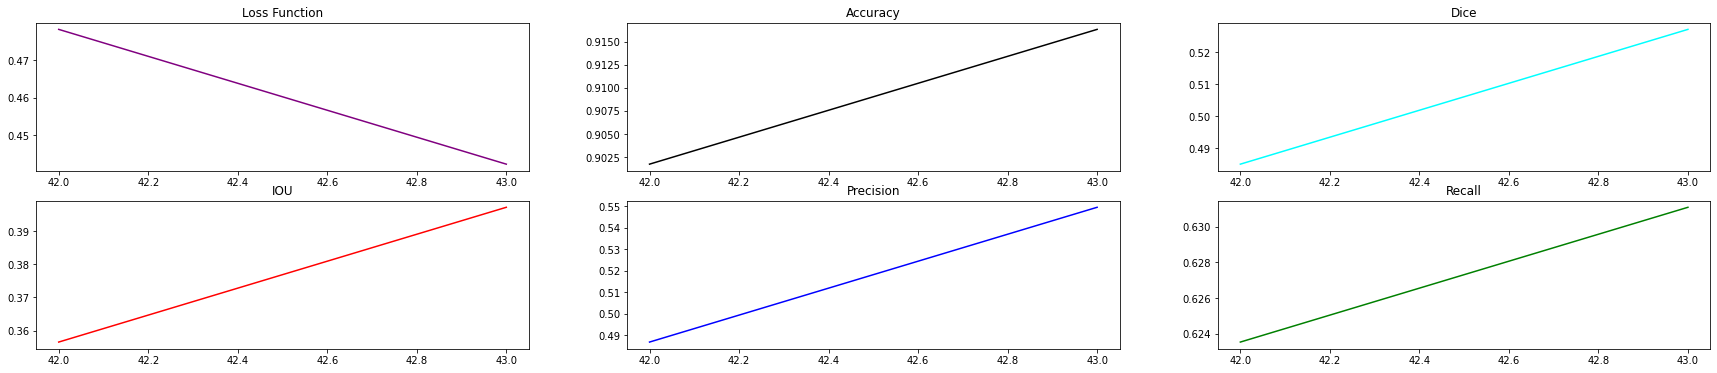

Test plots:


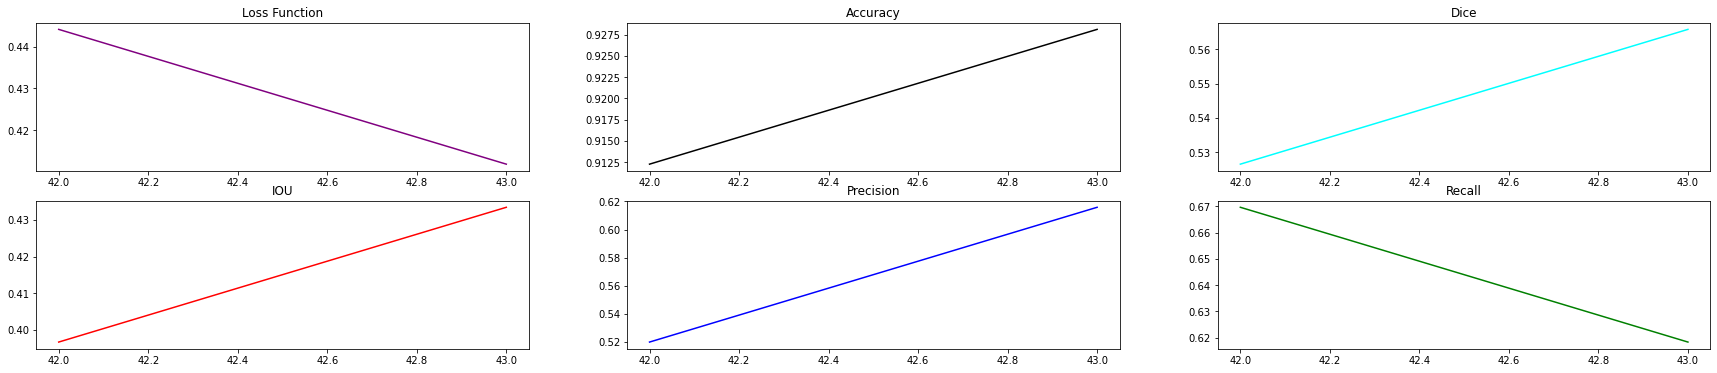

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 44/300


train_loss: 0.4196957047523815
train_accuracy: 0.9238325964400184
train_sensitivity: 0.6366027021186167
train_dice: 0.5557657170664663
train_precision 0.5897229278635834
train_recall 0.6366027021186167
IOU: 0.4252864039298778
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9303917518028846
Test Sensitivity :  0.6671072711874714
Test Pecision :  0.6163025461273752
Test Recall :  0.6671072711874714
Test loss :  0.3947964343395862
Test IOU :  0.4556444887713198
Test Dice :  0.5865557324755323
Train plots:


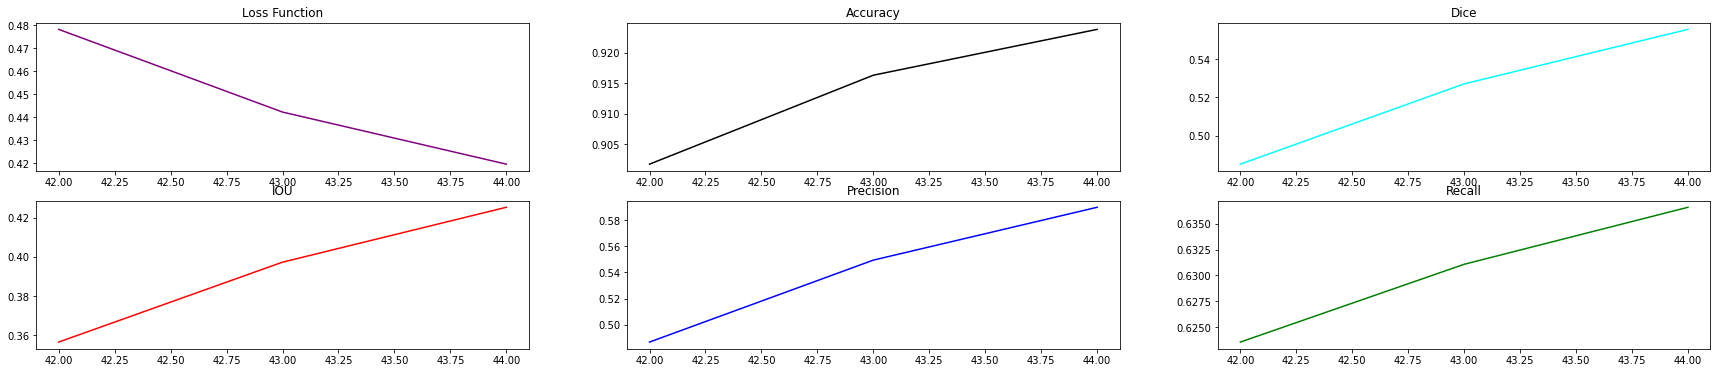

Test plots:


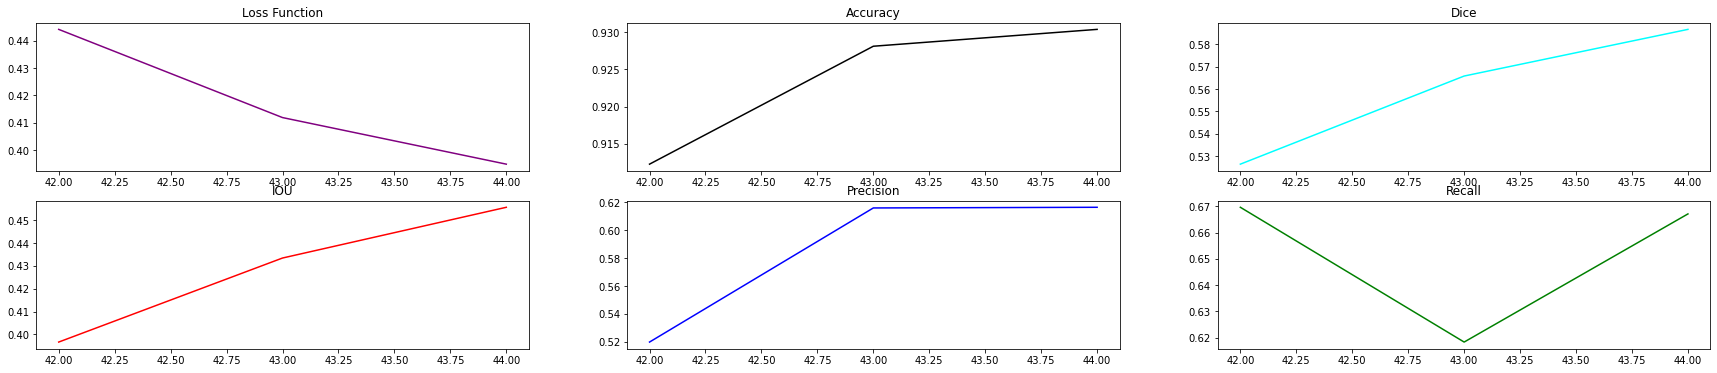

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 45/300


train_loss: 0.3952549792853467
train_accuracy: 0.9288474282065591
train_sensitivity: 0.6619832977966402
train_dice: 0.58785503569158
train_precision 0.6221982658236891
train_recall 0.6619832977966402
IOU: 0.4572348070199577
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9291503123747997
Test Sensitivity :  0.690899412273924
Test Pecision :  0.6059943118811527
Test Recall :  0.690899412273924
Test loss :  0.38627149421216805
Test IOU :  0.4705248263292697
Test Dice :  0.5982011508592319
Train plots:


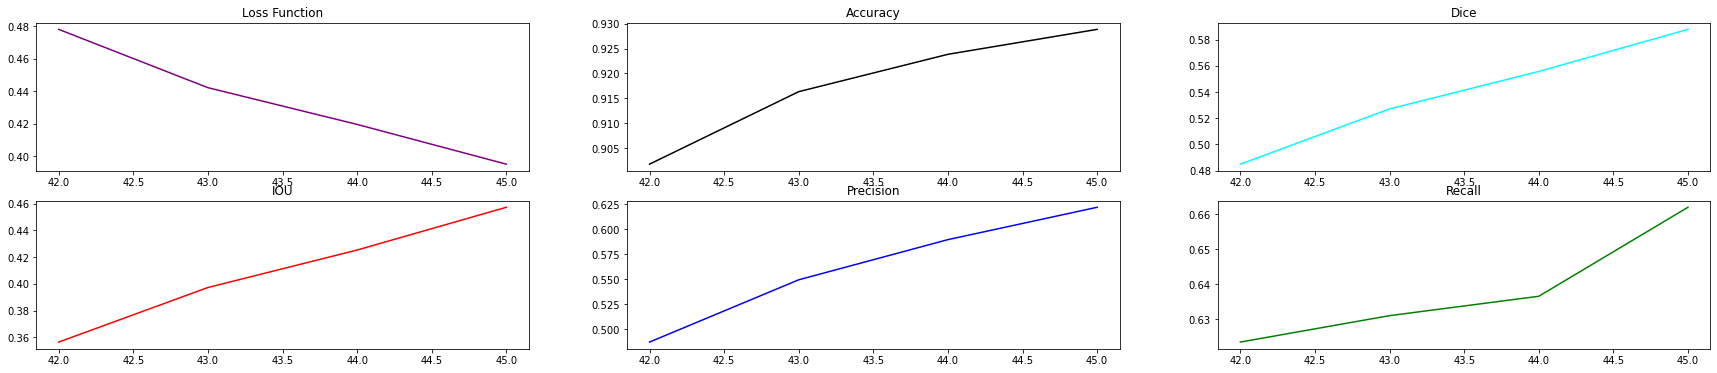

Test plots:


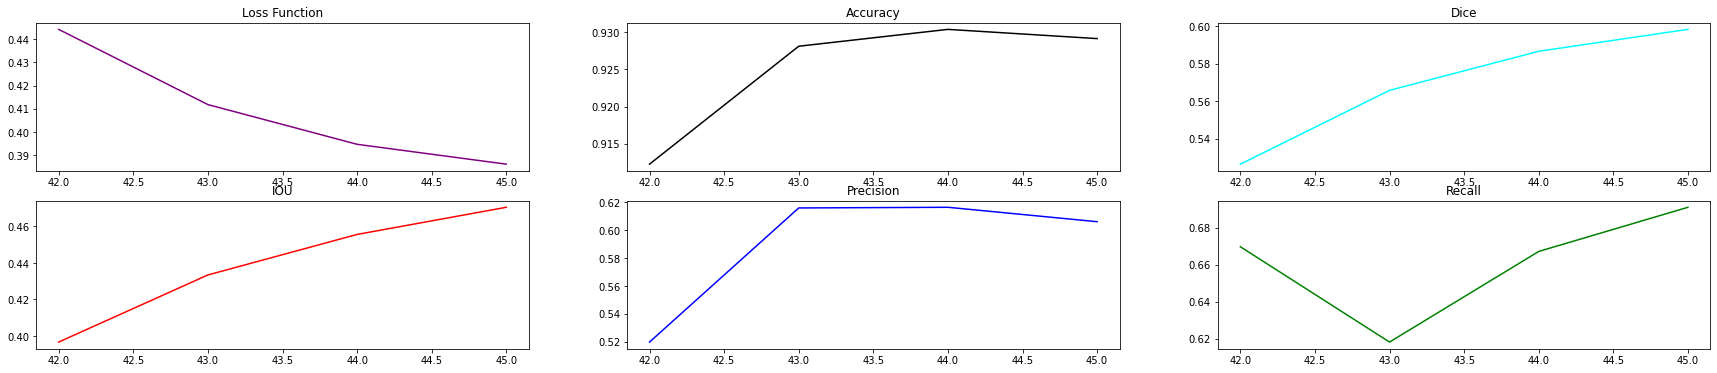

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 46/300


train_loss: 0.3769449648948816
train_accuracy: 0.9339100205417954
train_sensitivity: 0.6730074356075533
train_dice: 0.6089405358029997
train_precision 0.6461833763665915
train_recall 0.6730074356075533
IOU: 0.4793313490047764
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9406914903130723
Test Sensitivity :  0.6282193809201866
Test Pecision :  0.7308170192844266
Test Recall :  0.6282193809201866
Test loss :  0.35694572253104967
Test IOU :  0.5038842281579098
Test Dice :  0.6332867521069425
Train plots:


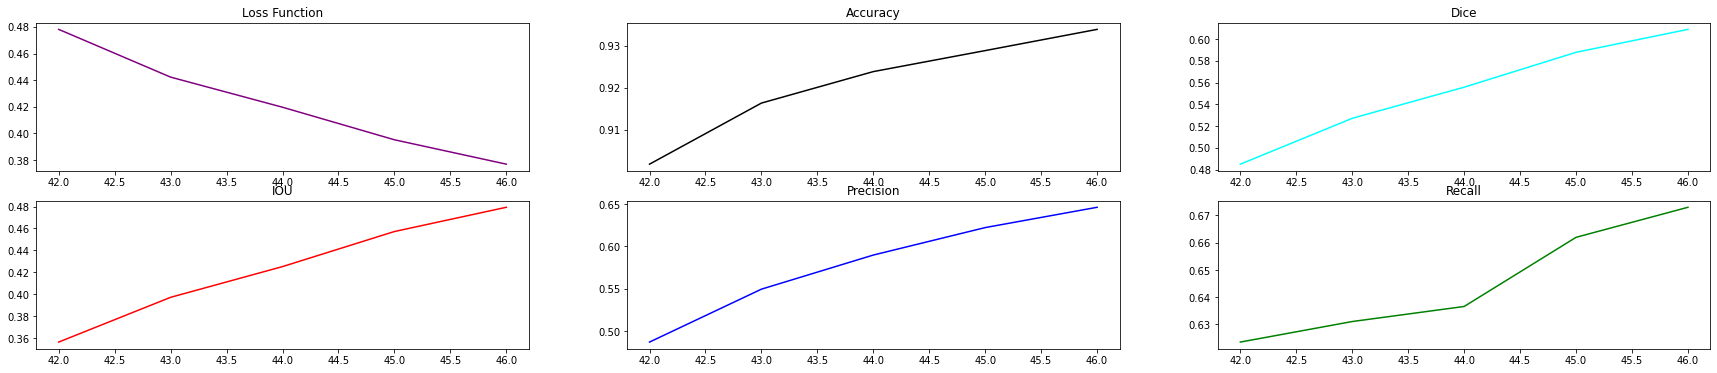

Test plots:


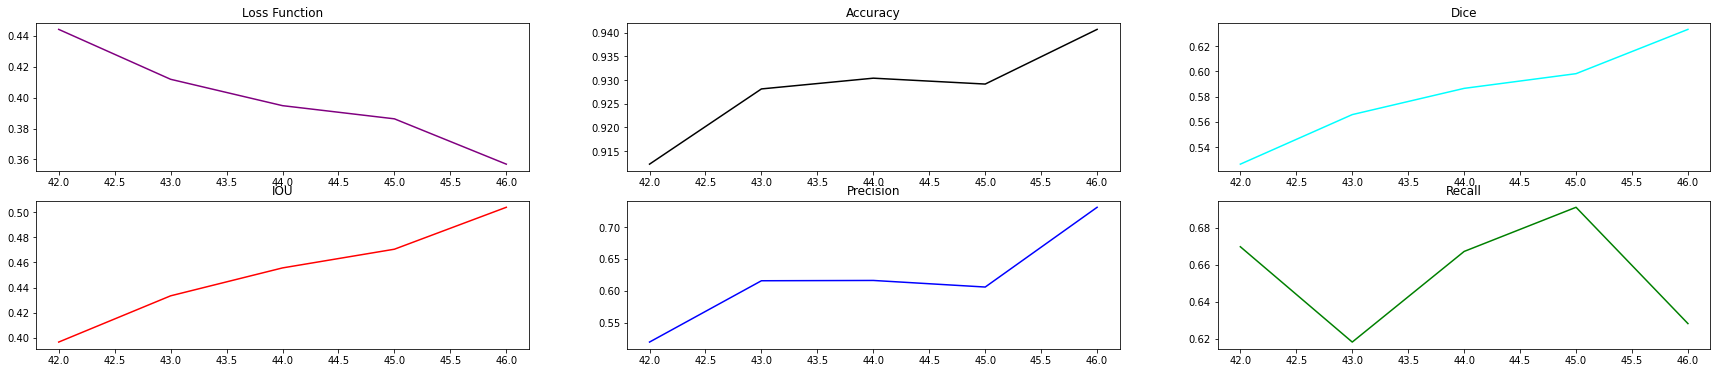

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 47/300


train_loss: 0.36613419475954967
train_accuracy: 0.9356864398215716
train_sensitivity: 0.686951856865742
train_dice: 0.6223193920211484
train_precision 0.656137266544064
train_recall 0.686951856865742
IOU: 0.4928750093188819
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9376638782766712
Test Sensitivity :  0.7185865688673306
Test Pecision :  0.6580916743575435
Test Recall :  0.7185865688673306
Test loss :  0.3494034931336567
Test IOU :  0.5143434852907509
Test Dice :  0.644019046545902
Train plots:


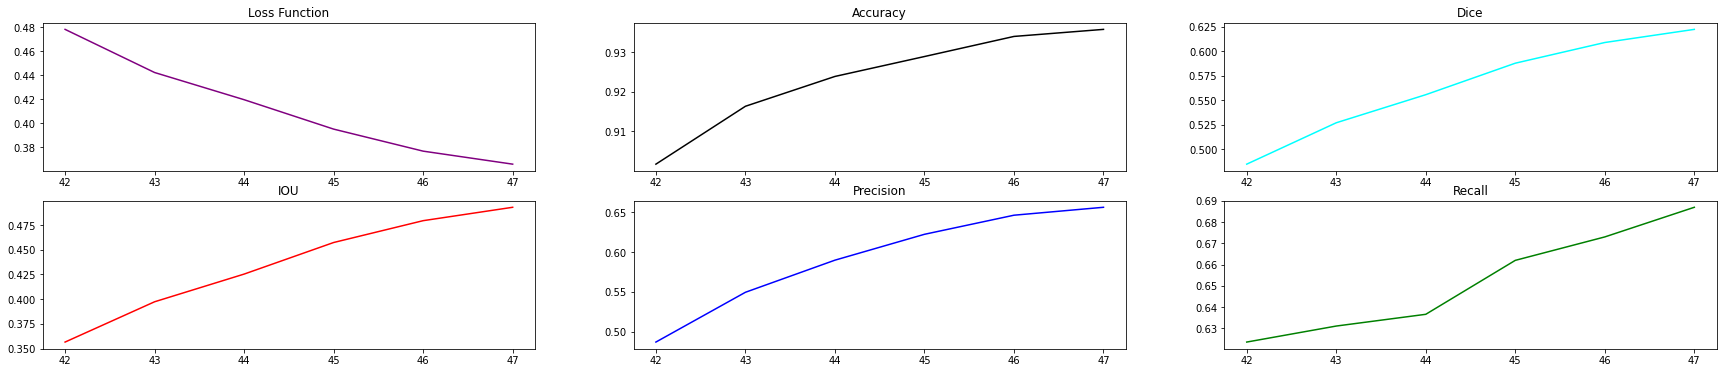

Test plots:


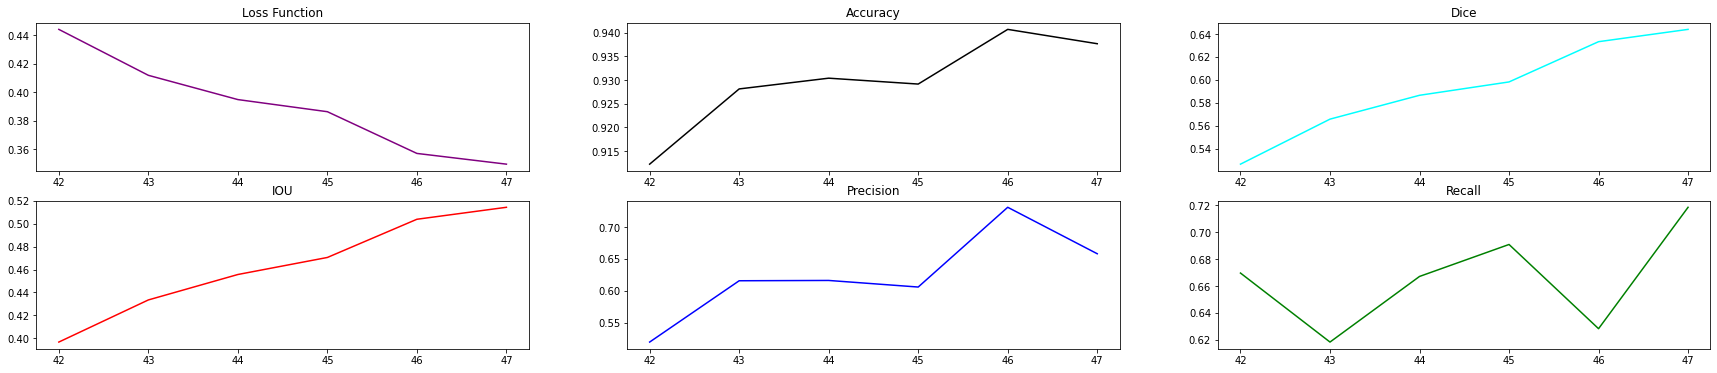

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 48/300


train_loss: 0.3534420561181866
train_accuracy: 0.9380748874538547
train_sensitivity: 0.6895297265359143
train_dice: 0.6368786766681642
train_precision 0.6749061933546344
train_recall 0.6895297265359143
IOU: 0.5110773565239126
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9396559048048306
Test Sensitivity :  0.7613533215645032
Test Pecision :  0.6445995512462798
Test Recall :  0.7613533215645032
Test loss :  0.3419329744555575
Test IOU :  0.5253544622288518
Test Dice :  0.6538710262312557
Train plots:


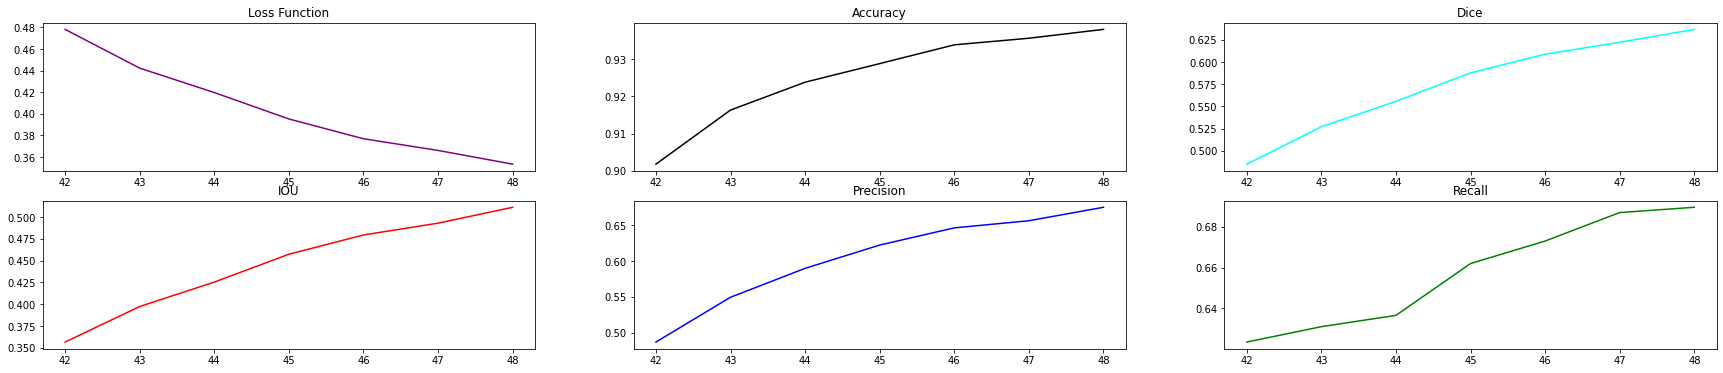

Test plots:


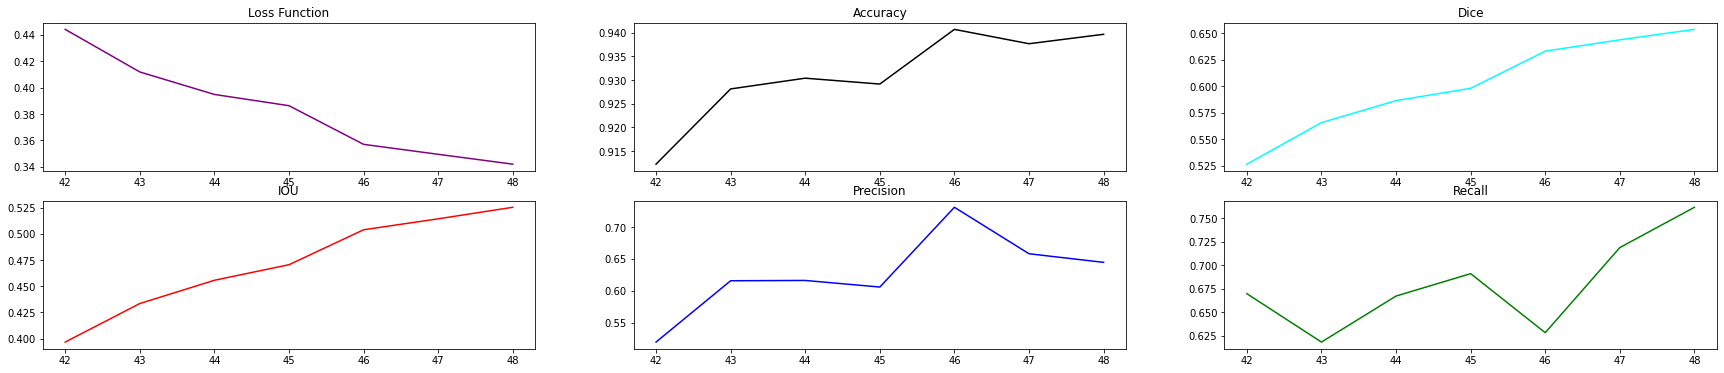

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 49/300


train_loss: 0.3404795996462687
train_accuracy: 0.9403221773140596
train_sensitivity: 0.7033553569587868
train_dice: 0.6530400375970349
train_precision 0.687794259378359
train_recall 0.7033553569587868
IOU: 0.5267619221397051
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9453018803299565
Test Sensitivity :  0.6852961948939732
Test Pecision :  0.7292234539548993
Test Recall :  0.6852961948939732
Test loss :  0.3244348602853852
Test IOU :  0.5449302030570341
Test Dice :  0.6703167590466175
Train plots:


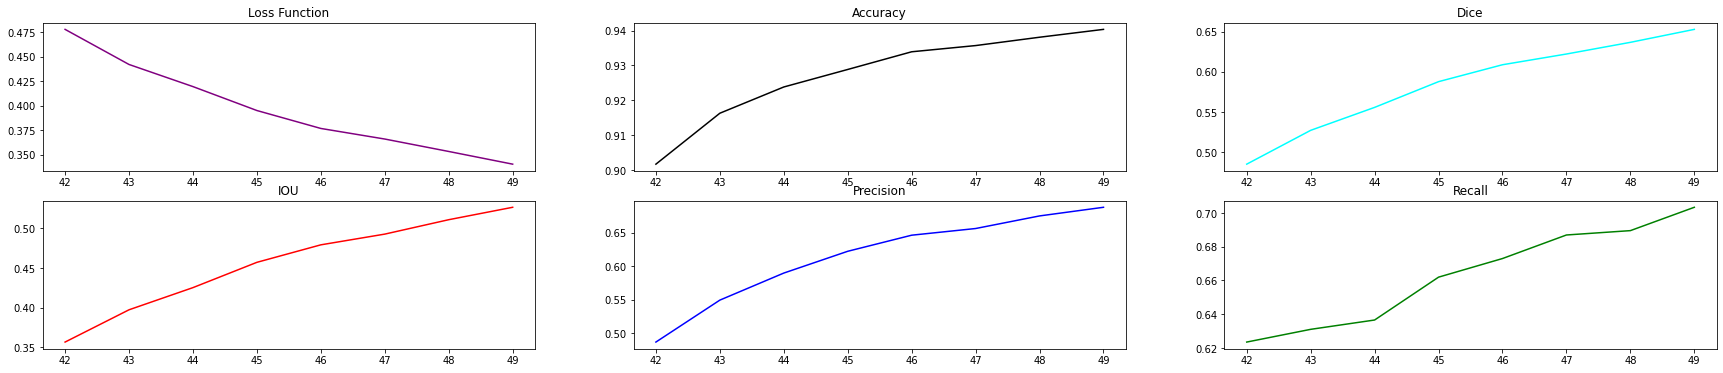

Test plots:


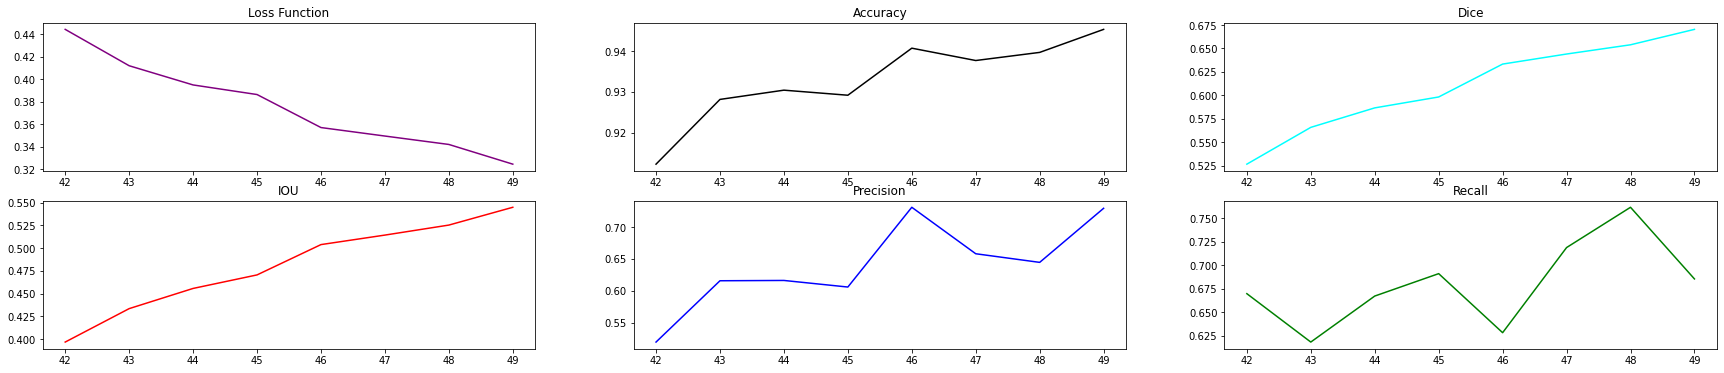

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 50/300


train_loss: 0.326843483523626
train_accuracy: 0.9435542738917984
train_sensitivity: 0.7162981715843068
train_dice: 0.6695283519875108
train_precision 0.7032473415294969
train_recall 0.7162981715843068
IOU: 0.5453310897074906
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9449837373726534
Test Sensitivity :  0.6712092584742732
Test Pecision :  0.7340108012105082
Test Recall :  0.6712092584742732
Test loss :  0.32658819401220524
Test IOU :  0.5435116387112237
Test Dice :  0.6680691897214114
Train plots:


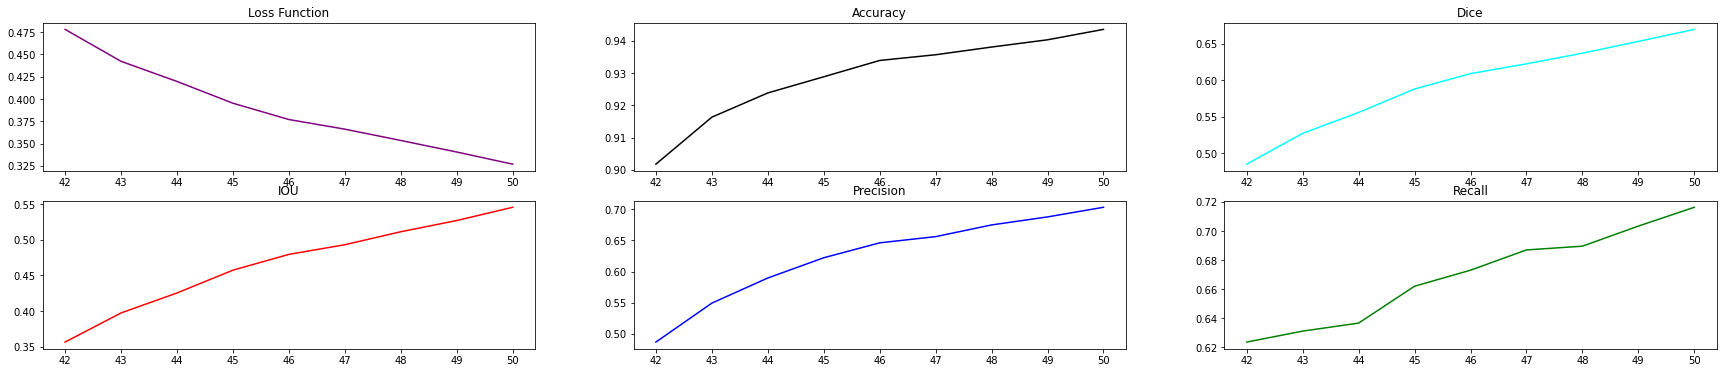

Test plots:


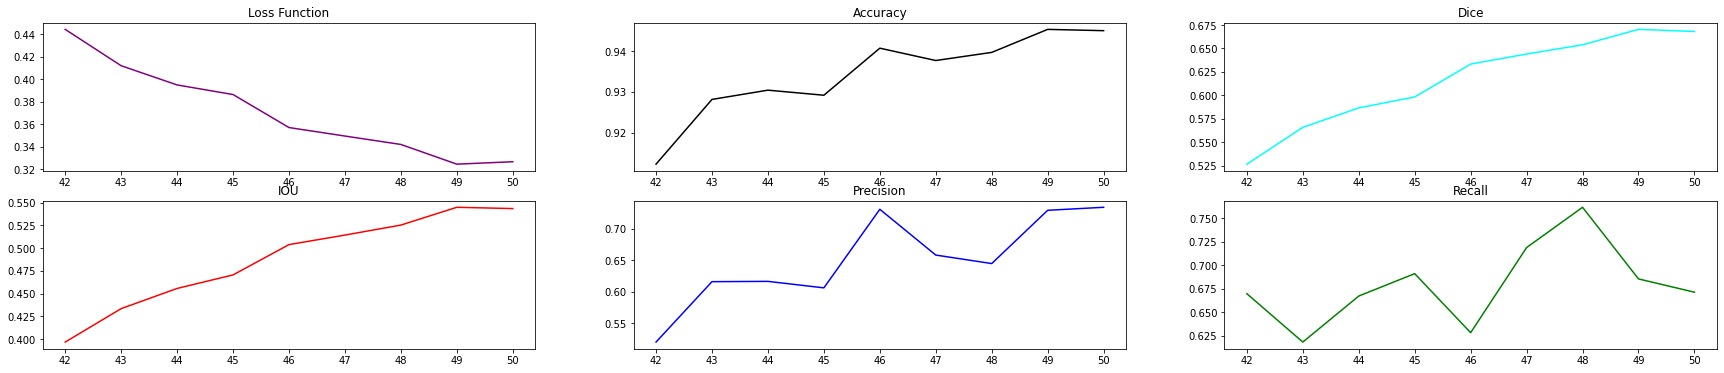

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 51/300


train_loss: 0.32450409107346895
train_accuracy: 0.9439113183772607
train_sensitivity: 0.7147395333766446
train_dice: 0.6713987561693285
train_precision 0.7067862099723979
train_recall 0.7147395333766446
IOU: 0.5485411874775948
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9507170177641369
Test Sensitivity :  0.730862292614612
Test Pecision :  0.75712401002318
Test Recall :  0.730862292614612
Test loss :  0.2909969008449233
Test IOU :  0.5904293409633986
Test Dice :  0.7097192002740098
Train plots:


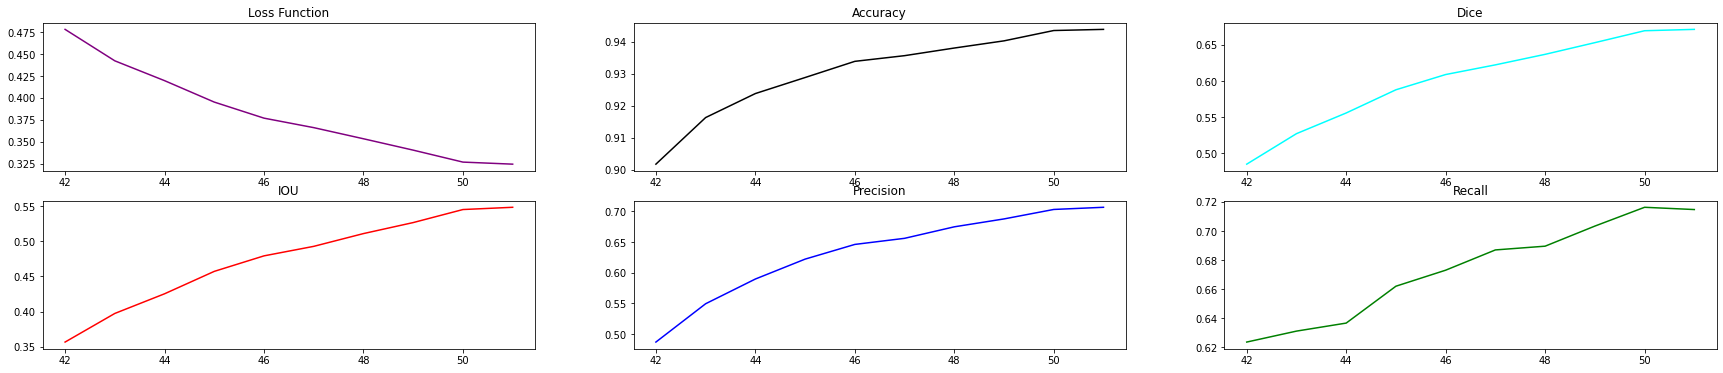

Test plots:


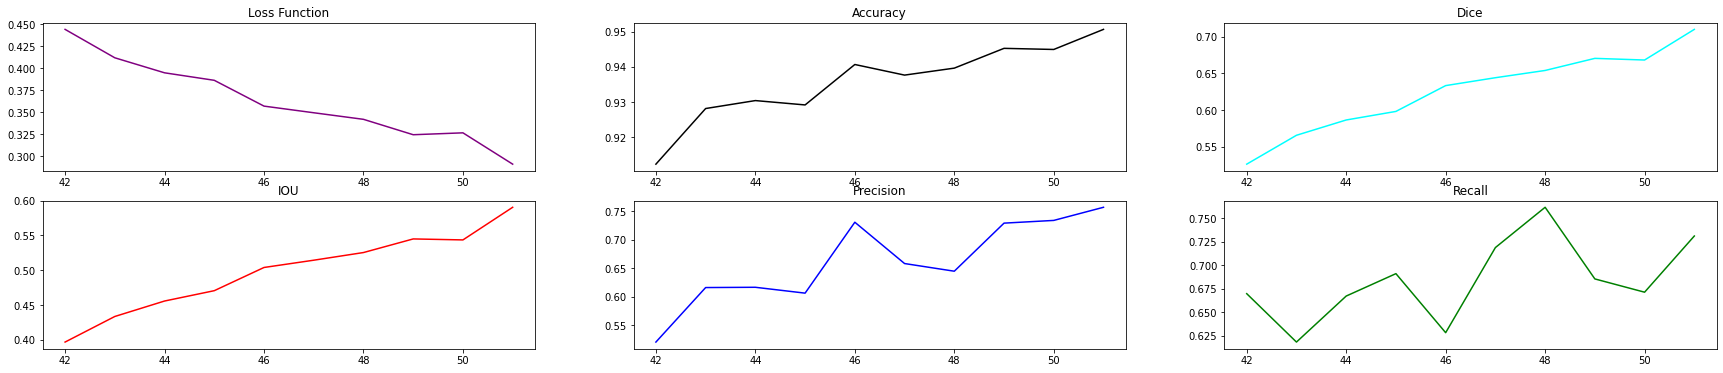

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 52/300


train_loss: 0.31530527977934686
train_accuracy: 0.9456082019177112
train_sensitivity: 0.7191316477729233
train_dice: 0.6819360969722912
train_precision 0.7189741945518914
train_recall 0.7191316477729233
IOU: 0.5597922897884015
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.951500972985348
Test Sensitivity :  0.7354475307813931
Test Pecision :  0.7503957224416209
Test Recall :  0.7354475307813931
Test loss :  0.2888867724072802
Test IOU :  0.5949203435317937
Test Dice :  0.7134012634500916
Train plots:


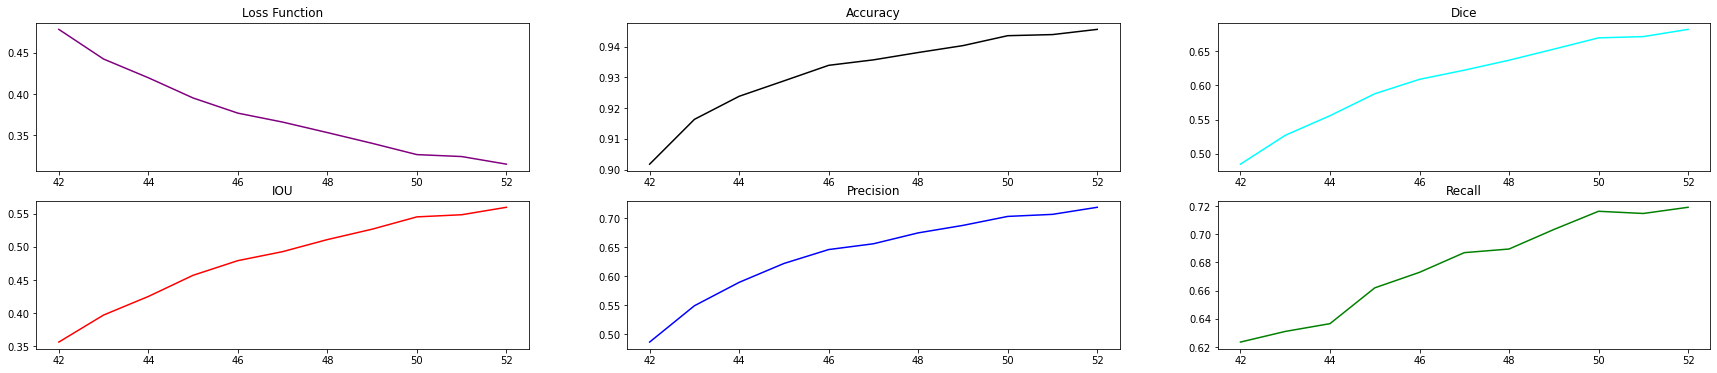

Test plots:


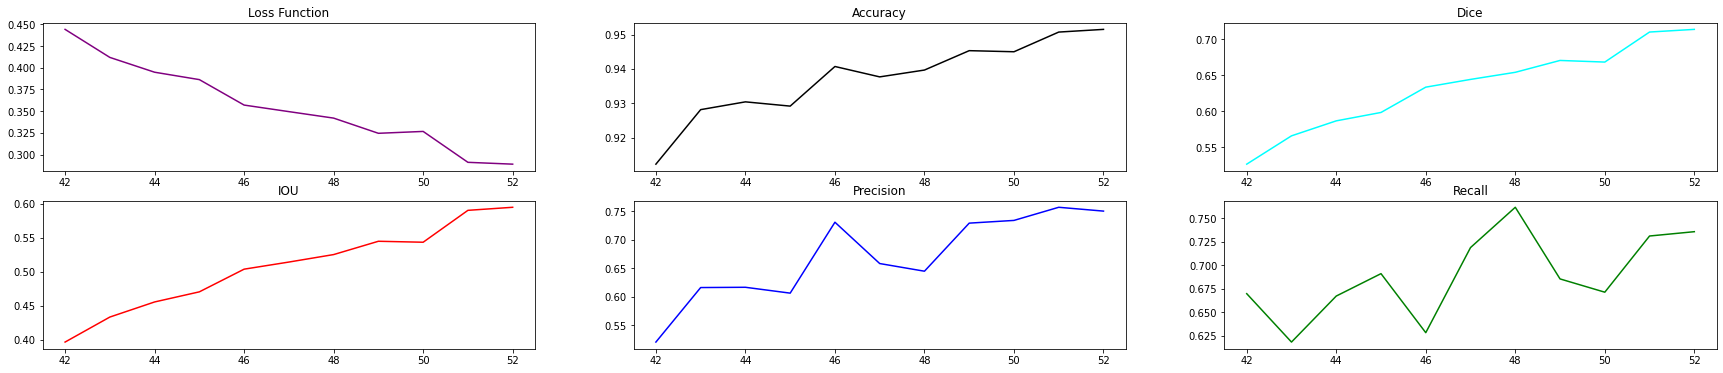

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 53/300


train_loss: 0.3052492327101174
train_accuracy: 0.9477845356141255
train_sensitivity: 0.7334717160539408
train_dice: 0.6940102669659443
train_precision 0.725366795466997
train_recall 0.7334717160539408
IOU: 0.5721863559310771
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9439072381882441
Test Sensitivity :  0.5798913864862352
Test Pecision :  0.8015567094851763
Test Recall :  0.5798913864862352
Test loss :  0.34614146585429545
Test IOU :  0.5147767678285257
Test Dice :  0.6442721859439389
Train plots:


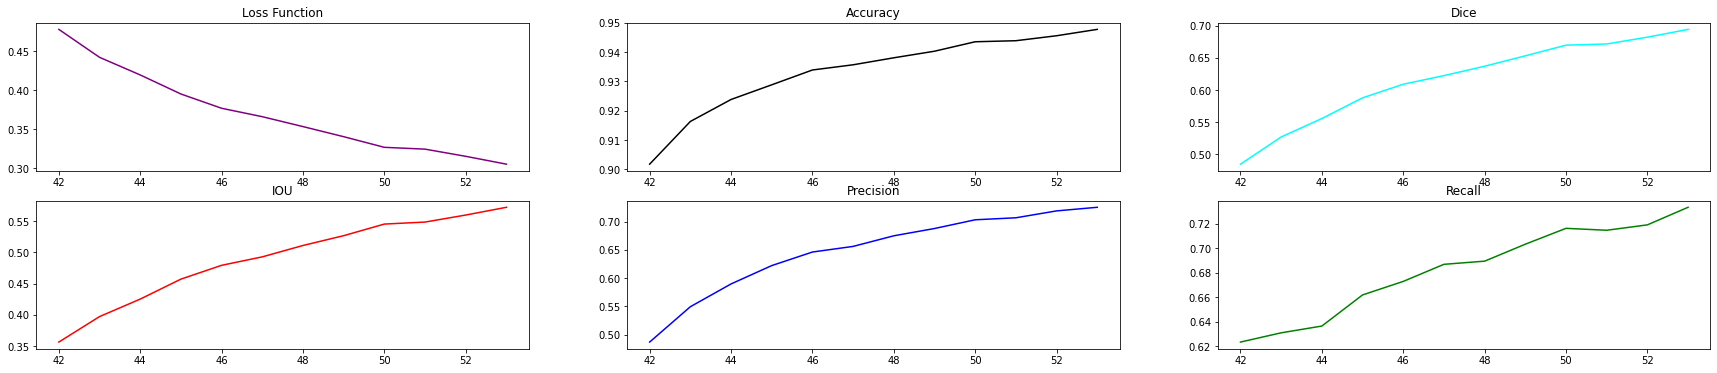

Test plots:


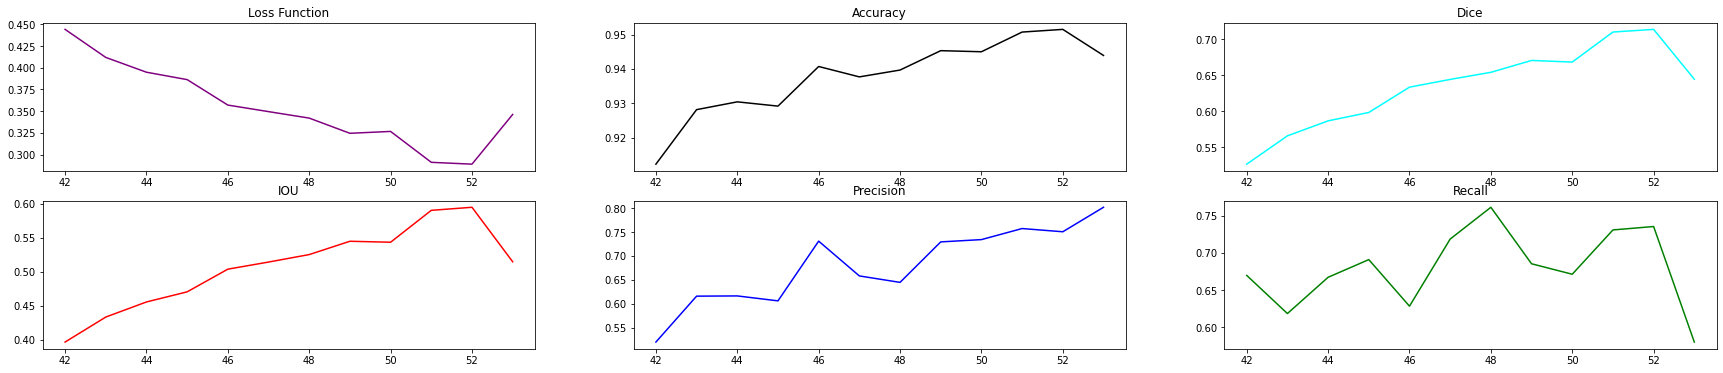

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 54/300


train_loss: 0.30507390295247455
train_accuracy: 0.9480851840623569
train_sensitivity: 0.7264033009352728
train_dice: 0.6934006571545412
train_precision 0.7269004319281481
train_recall 0.7264033009352728
IOU: 0.5712339365878313
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9497669485462454
Test Sensitivity :  0.7763426504728995
Test Pecision :  0.725286127446772
Test Recall :  0.7763426504728995
Test loss :  0.28602999732607887
Test IOU :  0.6004098186562786
Test Dice :  0.7192303444439675
Train plots:


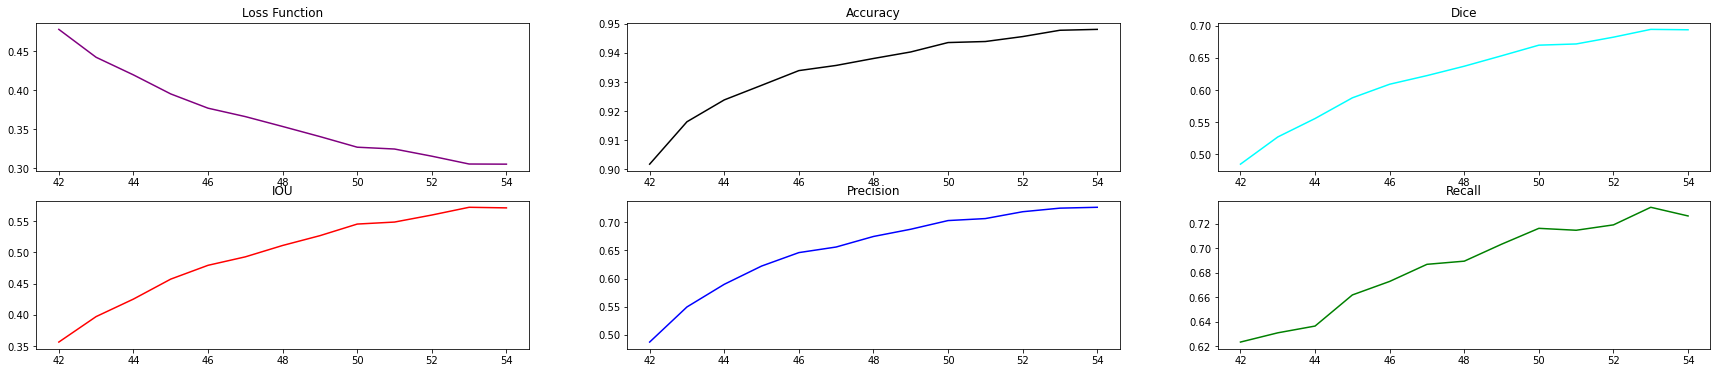

Test plots:


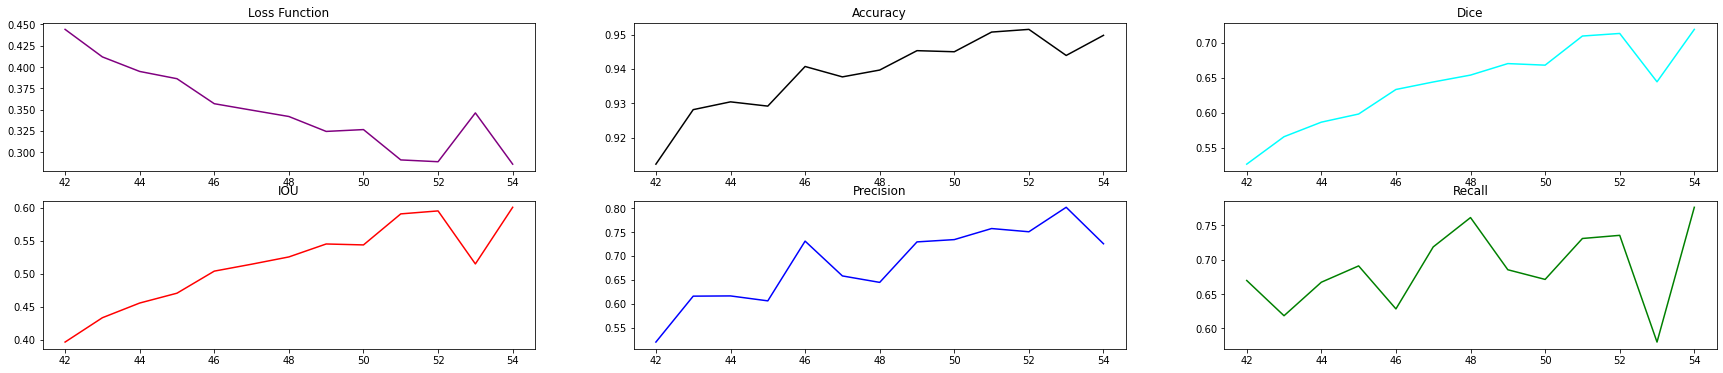

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 55/300


train_loss: 0.2971442329113955
train_accuracy: 0.9493435590695112
train_sensitivity: 0.7361723647733055
train_dice: 0.7032150477626158
train_precision 0.7356944948285793
train_recall 0.7361723647733055
IOU: 0.5825238513658245
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9540277837396978
Test Sensitivity :  0.7728559333326179
Test Pecision :  0.7538959656879579
Test Recall :  0.7728559333326179
Test loss :  0.26949715526986034
Test IOU :  0.6198481744898982
Test Dice :  0.7353963327931834
Train plots:


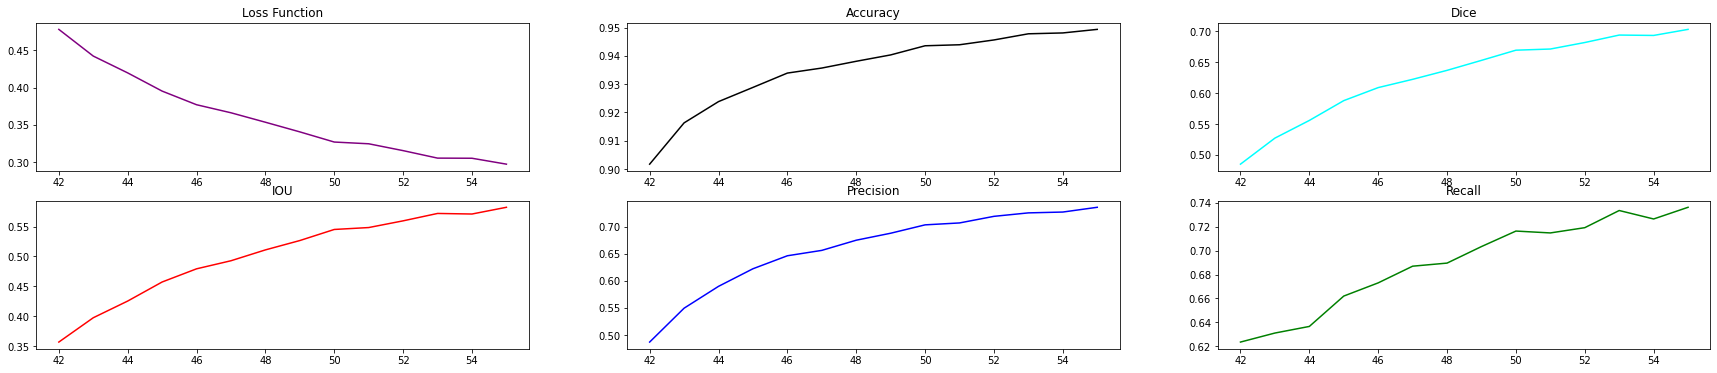

Test plots:


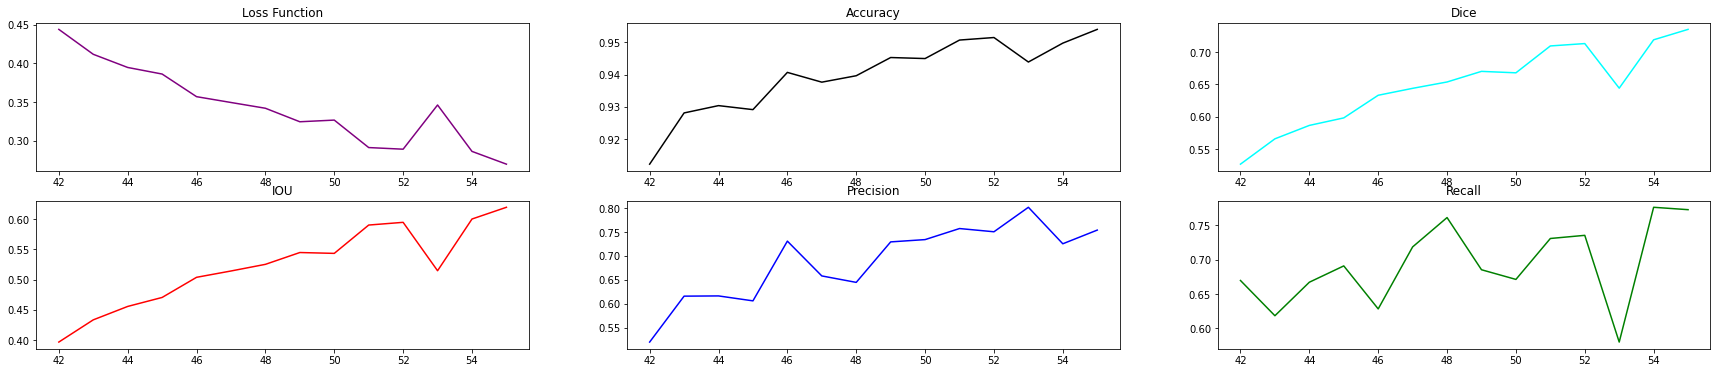

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 56/300


train_loss: 0.2891012669332844
train_accuracy: 0.9499688340630723
train_sensitivity: 0.7447087653801092
train_dice: 0.7125130821106935
train_precision 0.7439885504106744
train_recall 0.7447087653801092
IOU: 0.5934909118887968
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9437088180374313
Test Sensitivity :  0.7408033657423306
Test Pecision :  0.6955750294220753
Test Recall :  0.7408033657423306
Test loss :  0.3157727587354052
Test IOU :  0.5595175495077839
Test Dice :  0.6849399888035141
Train plots:


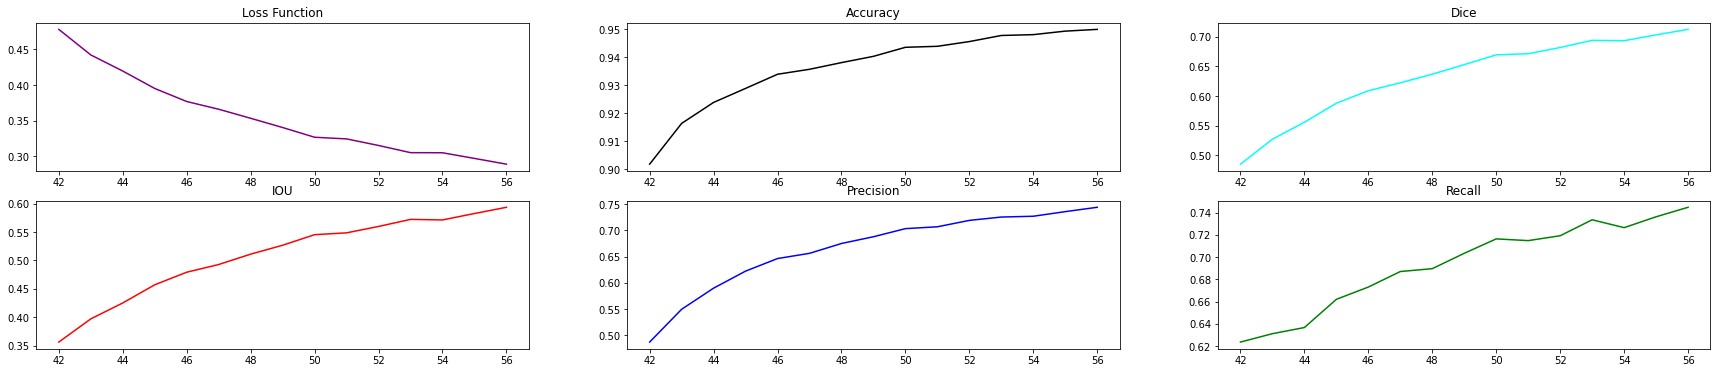

Test plots:


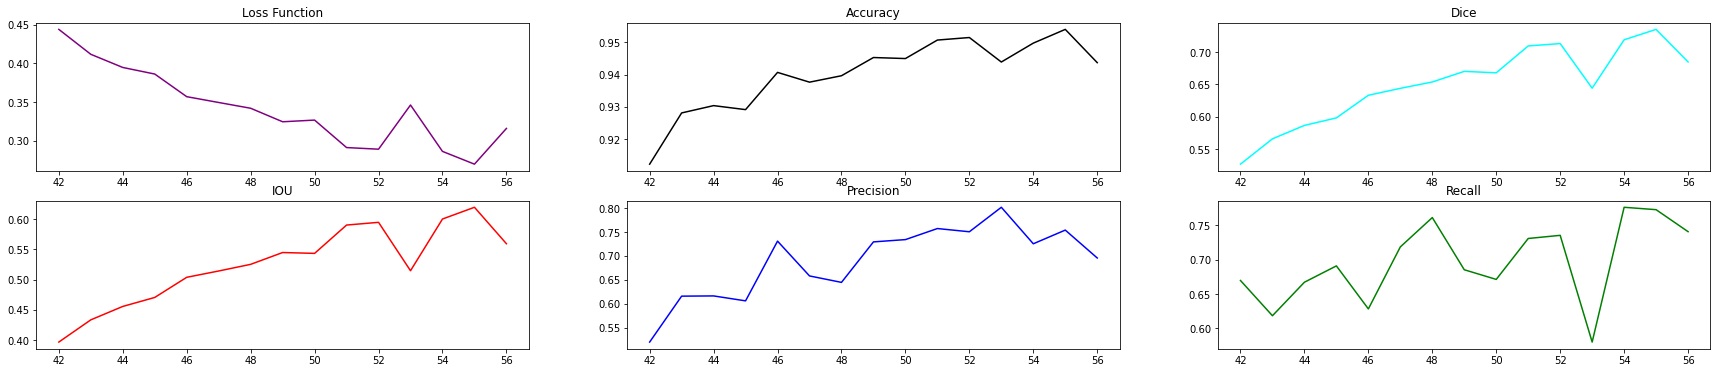

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 57/300


train_loss: 0.286774470153582
train_accuracy: 0.9510621290940505
train_sensitivity: 0.7429956445443161
train_dice: 0.7137670099441876
train_precision 0.7466375101391813
train_recall 0.7429956445443161
IOU: 0.5963765673647249
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9524518247052427
Test Sensitivity :  0.644810770894145
Test Pecision :  0.8130489251552484
Test Recall :  0.644810770894145
Test loss :  0.3008213252811642
Test IOU :  0.5740585047683436
Test Dice :  0.6960536970760359
Train plots:


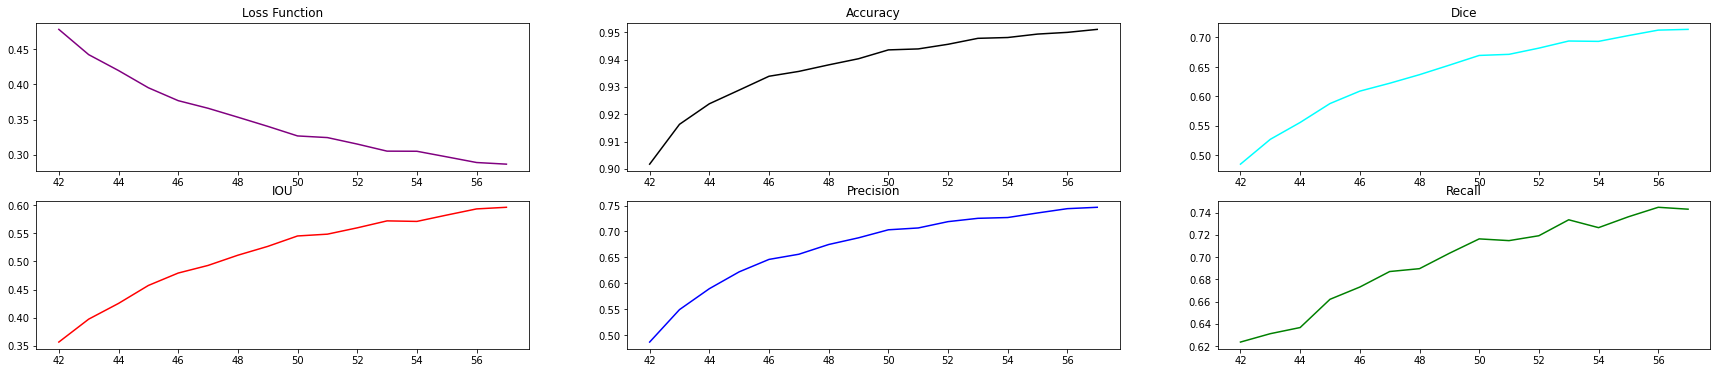

Test plots:


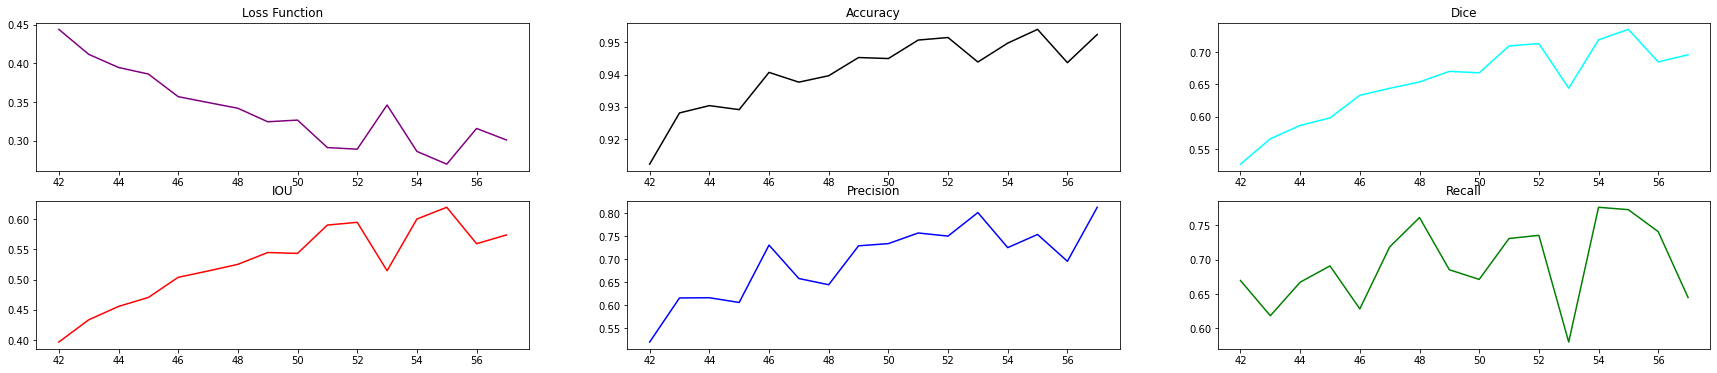

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 58/300


train_loss: 0.2815962410480766
train_accuracy: 0.9519998180123913
train_sensitivity: 0.7498704570293556
train_dice: 0.7194589328548731
train_precision 0.7443532813158127
train_recall 0.7498704570293556
IOU: 0.6013703680710356
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.956107674064217
Test Sensitivity :  0.7083585969694368
Test Pecision :  0.8212918571500114
Test Recall :  0.7083585969694368
Test loss :  0.2662674620911315
Test IOU :  0.6197323083004236
Test Dice :  0.7371381263593177
Train plots:


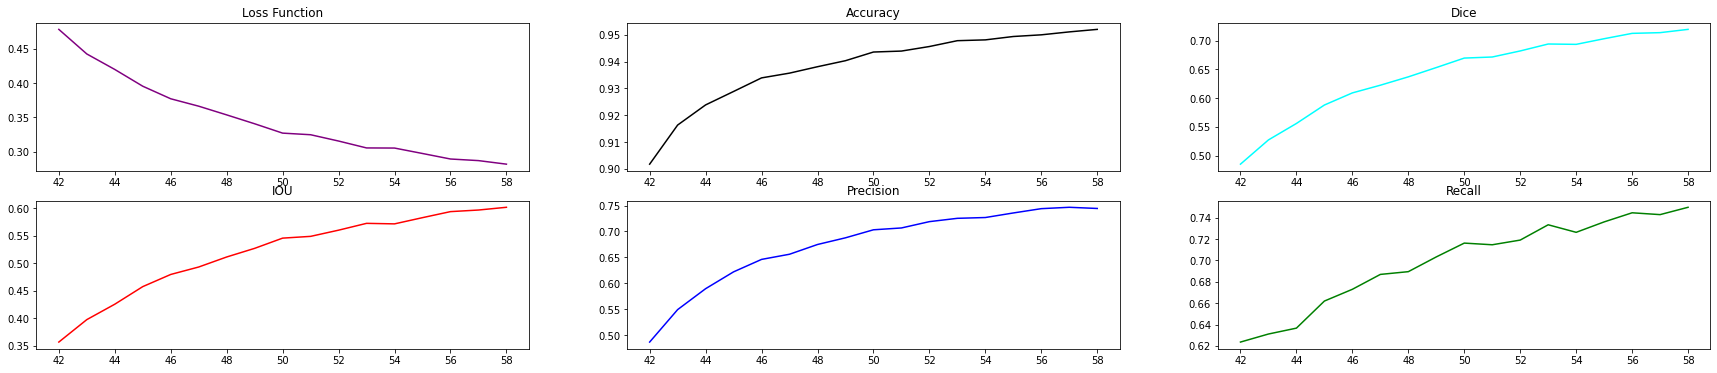

Test plots:


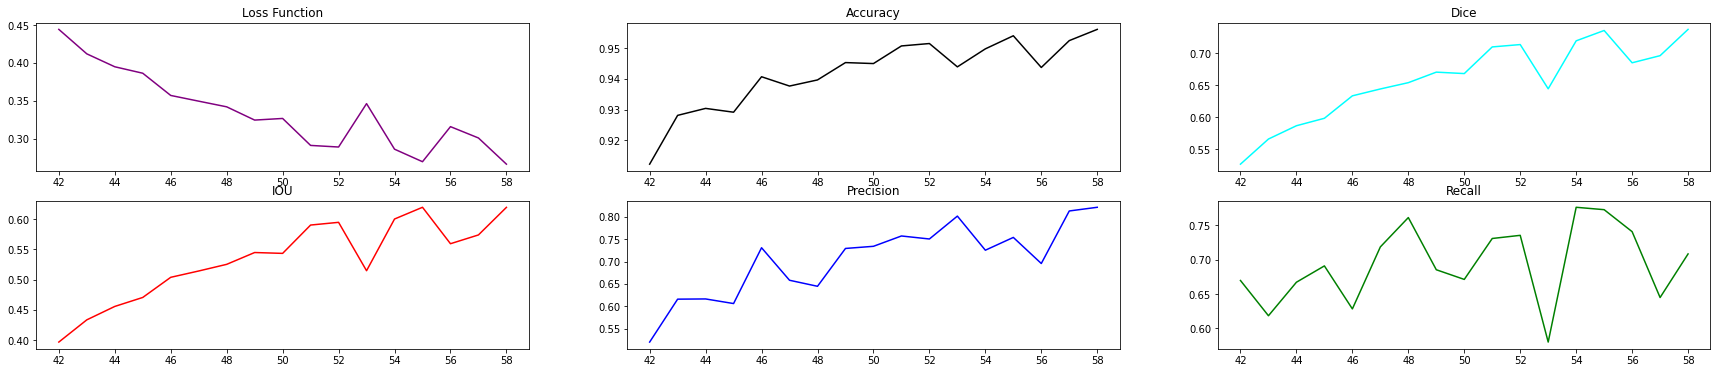

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 59/300


train_loss: 0.2766791633210885
train_accuracy: 0.952971685500372
train_sensitivity: 0.7493133044984165
train_dice: 0.7254017534138696
train_precision 0.7566359179369907
train_recall 0.7493133044984165
IOU: 0.6085895163769537
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9584786551339286
Test Sensitivity :  0.7644497937771864
Test Pecision :  0.7906227531013909
Test Recall :  0.7644497937771864
Test loss :  0.2514851608555832
Test IOU :  0.6415317521427141
Test Dice :  0.7543065556676396
Train plots:


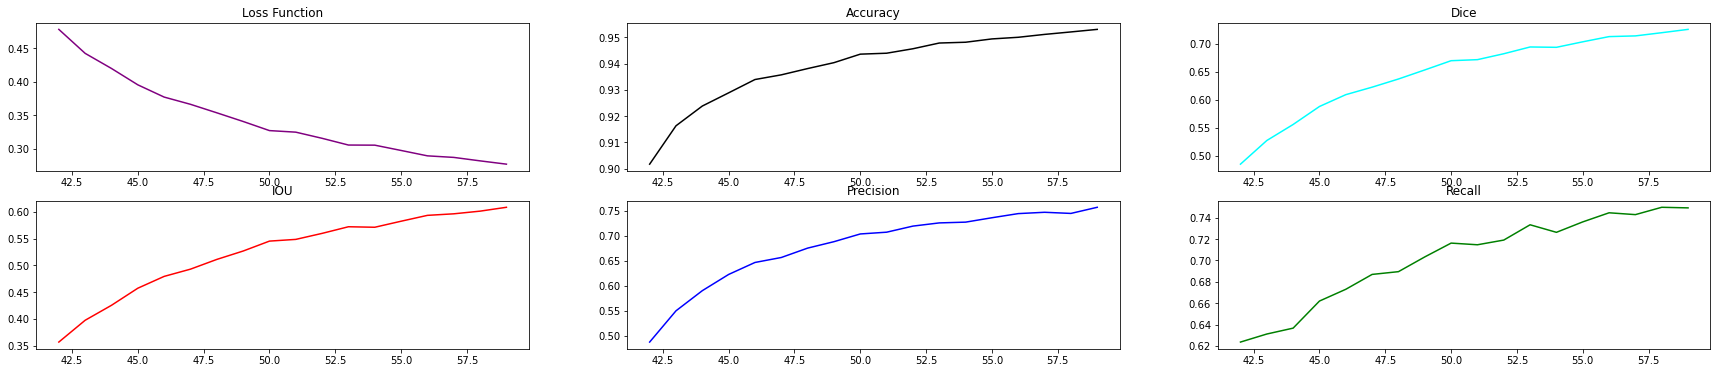

Test plots:


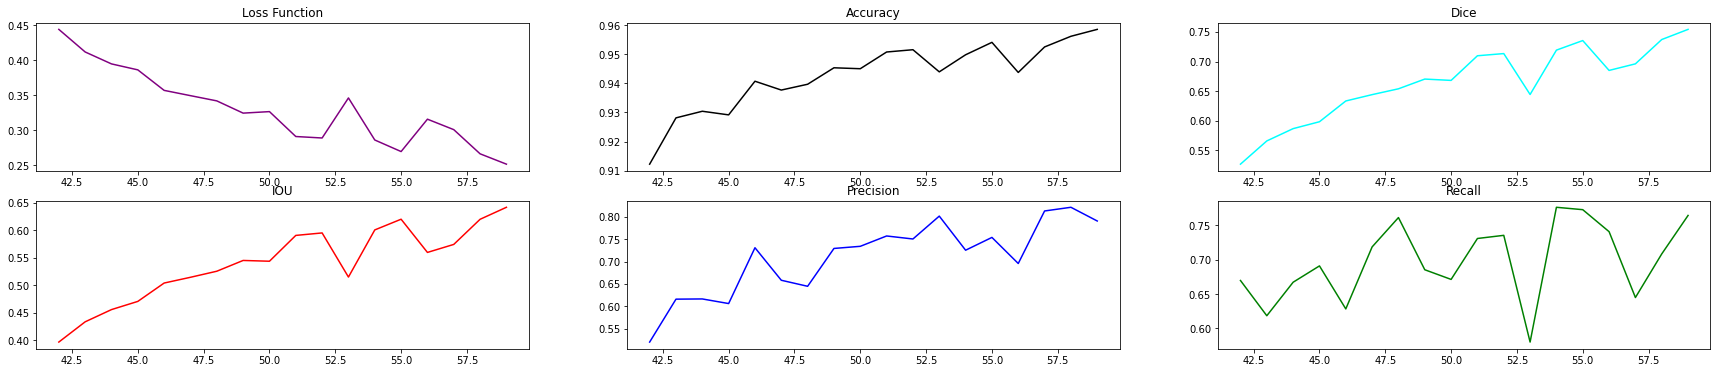

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 60/300


train_loss: 0.27332024342097316
train_accuracy: 0.9536974840548449
train_sensitivity: 0.753366823410513
train_dice: 0.7299767705388436
train_precision 0.7622089307536047
train_recall 0.753366823410513
IOU: 0.6112335119234404
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9569120861235119
Test Sensitivity :  0.7849203815390339
Test Pecision :  0.7674897022736378
Test Recall :  0.7849203815390339
Test loss :  0.253334716126159
Test IOU :  0.6405911288418613
Test Dice :  0.7521494212168041
Train plots:


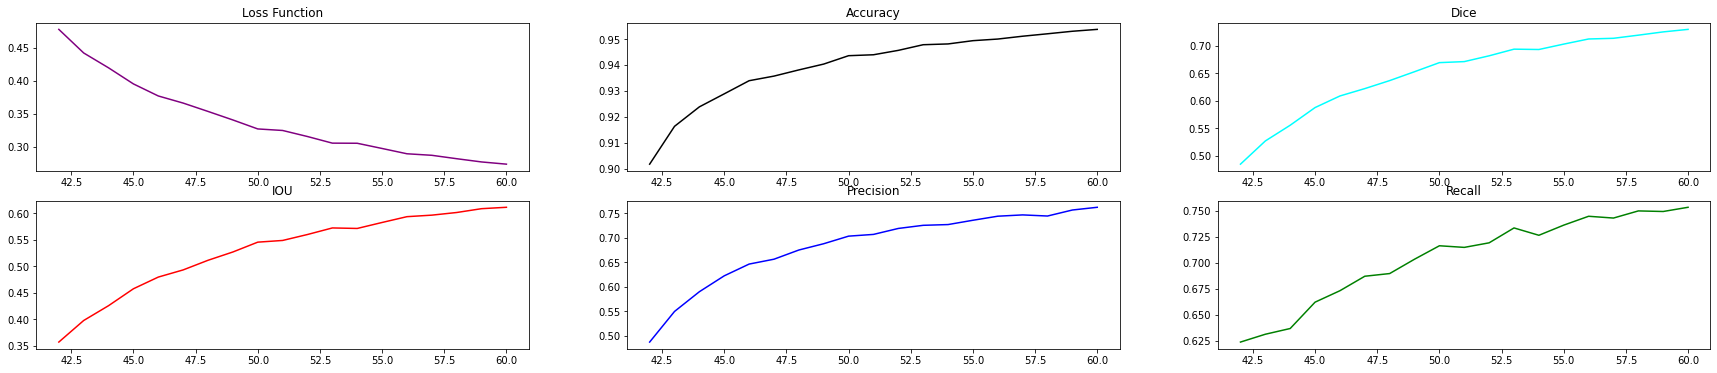

Test plots:


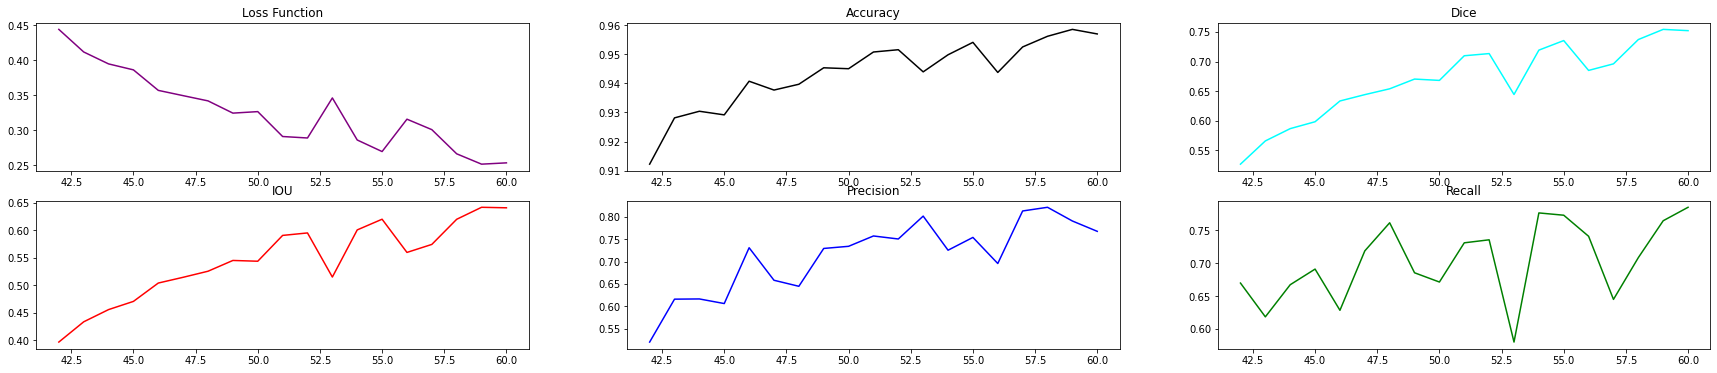

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 61/300


train_loss: 0.26979404305118126
train_accuracy: 0.9546798035338685
train_sensitivity: 0.7577080483111892
train_dice: 0.7334810105878852
train_precision 0.7640480108063353
train_recall 0.7577080483111892
IOU: 0.6174574033798824
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9566869491185898
Test Sensitivity :  0.69160645872682
Test Pecision :  0.8181351322830815
Test Recall :  0.69160645872682
Test loss :  0.2717484135330815
Test IOU :  0.6131370460594093
Test Dice :  0.7289072672526041
Train plots:


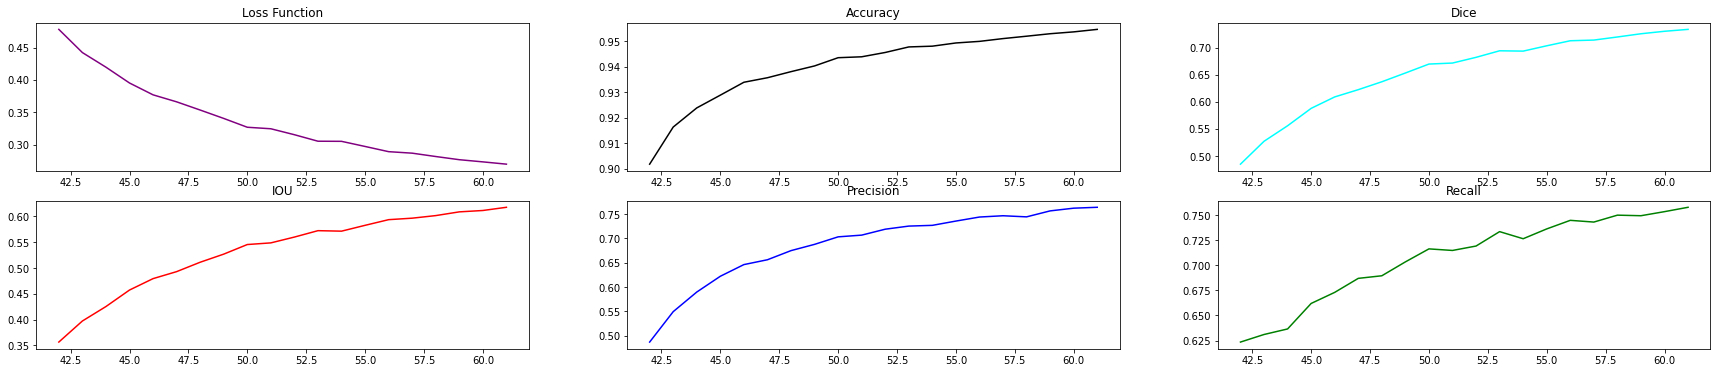

Test plots:


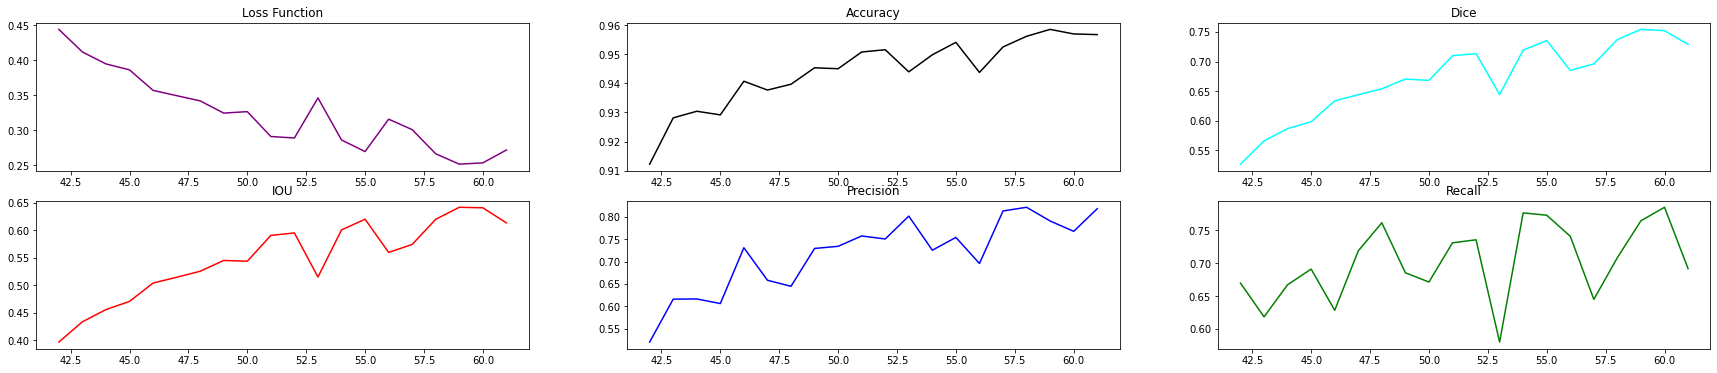

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 62/300


train_loss: 0.2643589692347216
train_accuracy: 0.9552408574701665
train_sensitivity: 0.7598085652882465
train_dice: 0.7390763317140999
train_precision 0.7677919686389848
train_recall 0.7598085652882465
IOU: 0.6257655910526926
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9576720073546245
Test Sensitivity :  0.6930039514115441
Test Pecision :  0.8418030232300252
Test Recall :  0.6930039514115441
Test loss :  0.2612339900090144
Test IOU :  0.6242023509937328
Test Dice :  0.7402572352370936
Train plots:


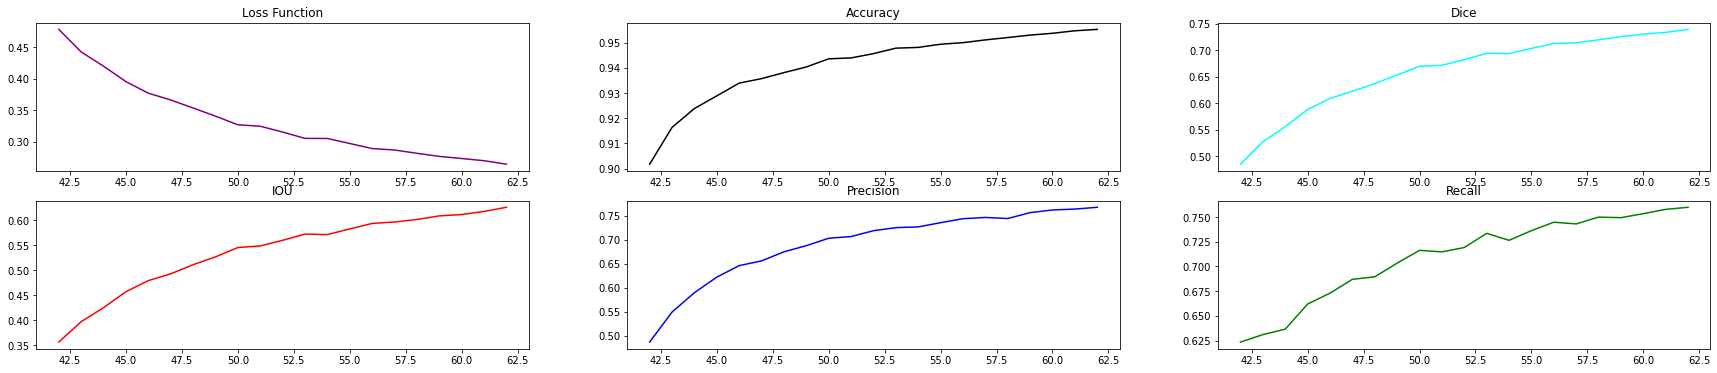

Test plots:


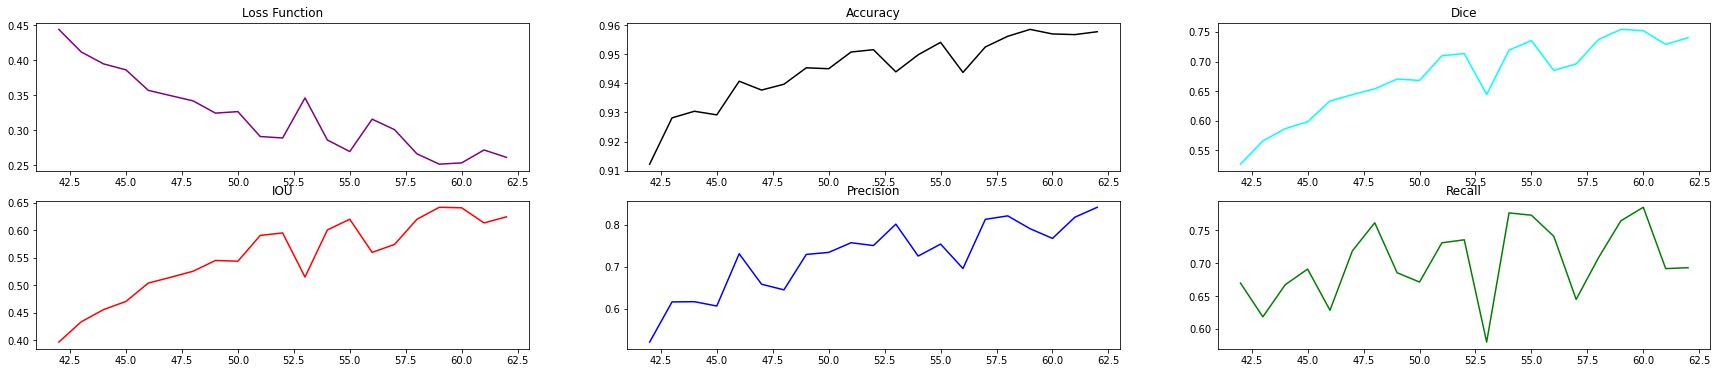

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 63/300


train_loss: 0.2610364960090363
train_accuracy: 0.9561632317064446
train_sensitivity: 0.7638295000681702
train_dice: 0.7433609623396291
train_precision 0.7719965042877301
train_recall 0.7638295000681702
IOU: 0.6284593984372948
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9594932248740843
Test Sensitivity :  0.8196462554372711
Test Pecision :  0.7595717880752061
Test Recall :  0.8196462554372711
Test loss :  0.24135916573660715
Test IOU :  0.6568112216152988
Test Dice :  0.7669019873762305
Train plots:


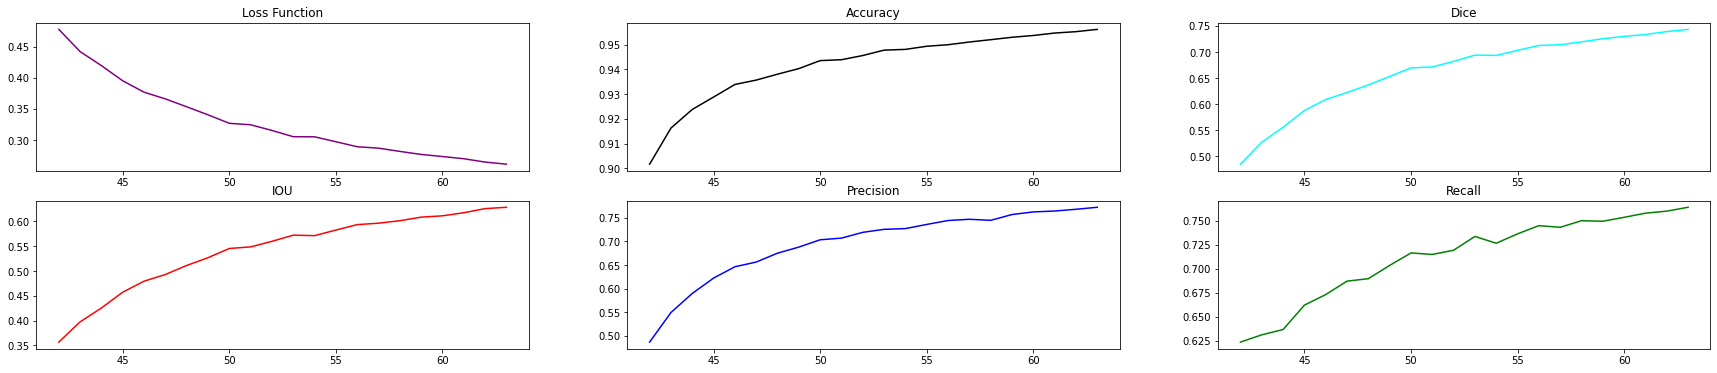

Test plots:


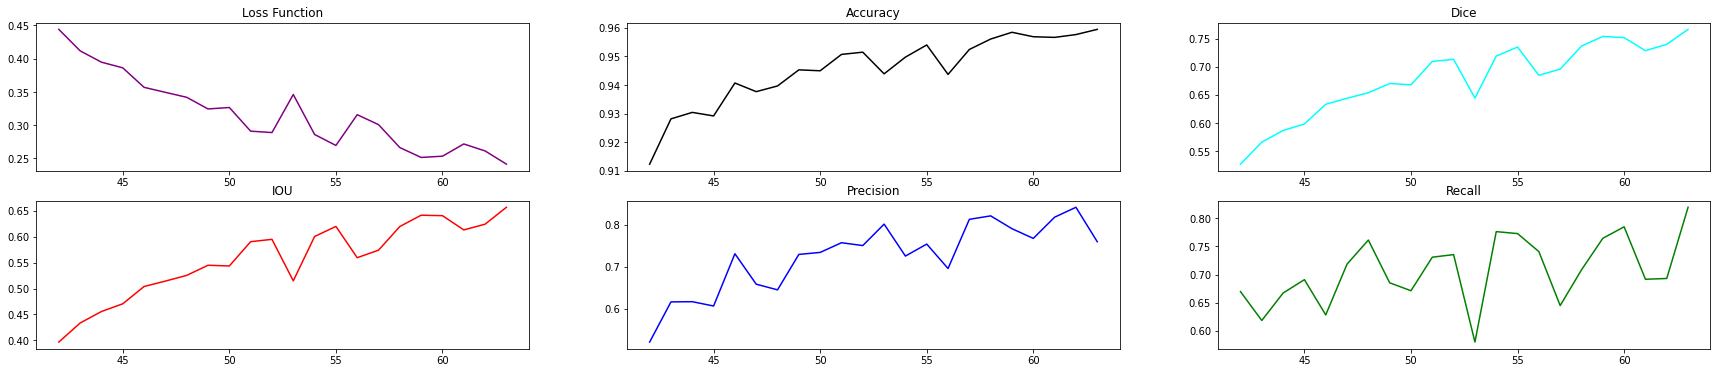

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 64/300


train_loss: 0.25287215360491483
train_accuracy: 0.9571340092809208
train_sensitivity: 0.7764607884975716
train_dice: 0.7525869859902754
train_precision 0.7768570598105698
train_recall 0.7764607884975716
IOU: 0.6391072278162601
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9605764312185211
Test Sensitivity :  0.7727537050351991
Test Pecision :  0.8020974183693911
Test Recall :  0.7727537050351991
Test loss :  0.23848109542231857
Test IOU :  0.658478509812128
Test Dice :  0.7669940990406078
Train plots:


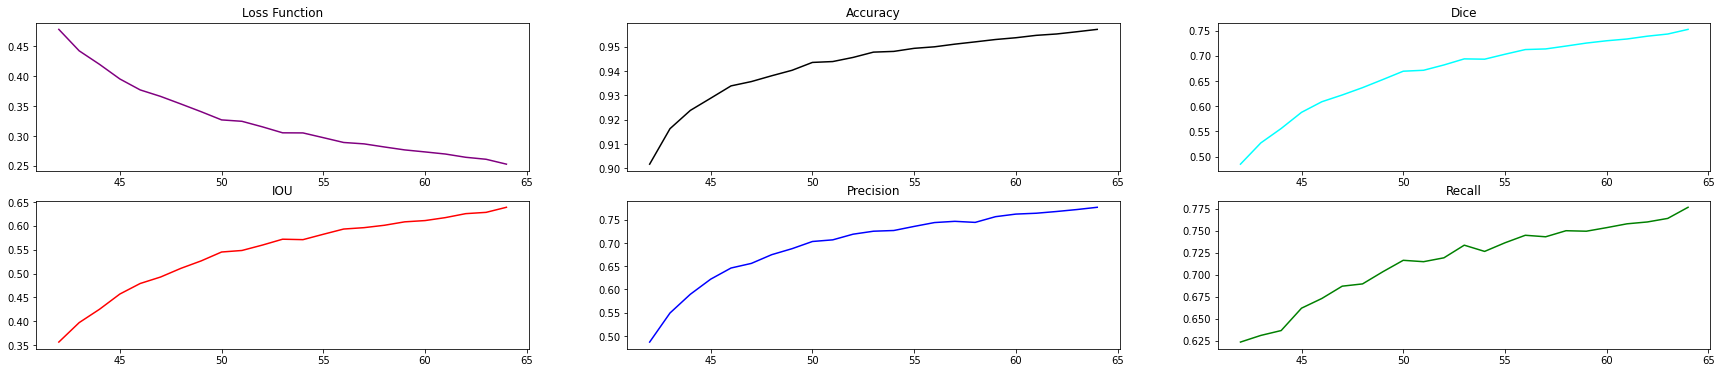

Test plots:


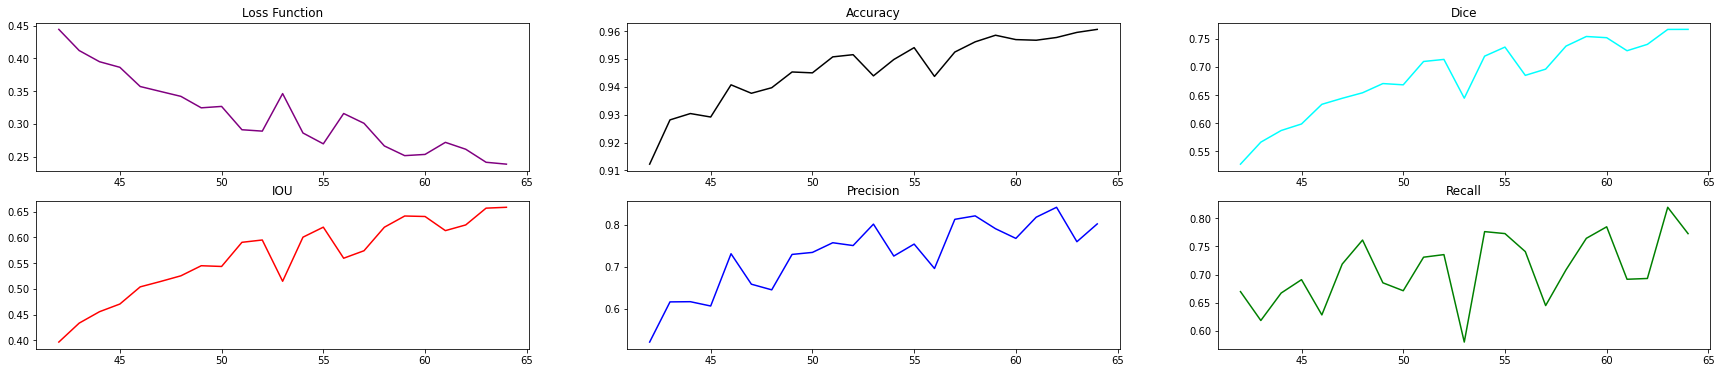

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 65/300


train_loss: 0.2511758103134322
train_accuracy: 0.9582041366633042
train_sensitivity: 0.772610134393053
train_dice: 0.7538924061236119
train_precision 0.7802149932946661
train_recall 0.772610134393053
IOU: 0.6405762464596209
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9578468406593407
Test Sensitivity :  0.7880212692987352
Test Pecision :  0.7699355799636561
Test Recall :  0.7880212692987352
Test loss :  0.24940015632154305
Test IOU :  0.6439742203597184
Test Dice :  0.7562367086445455
Train plots:


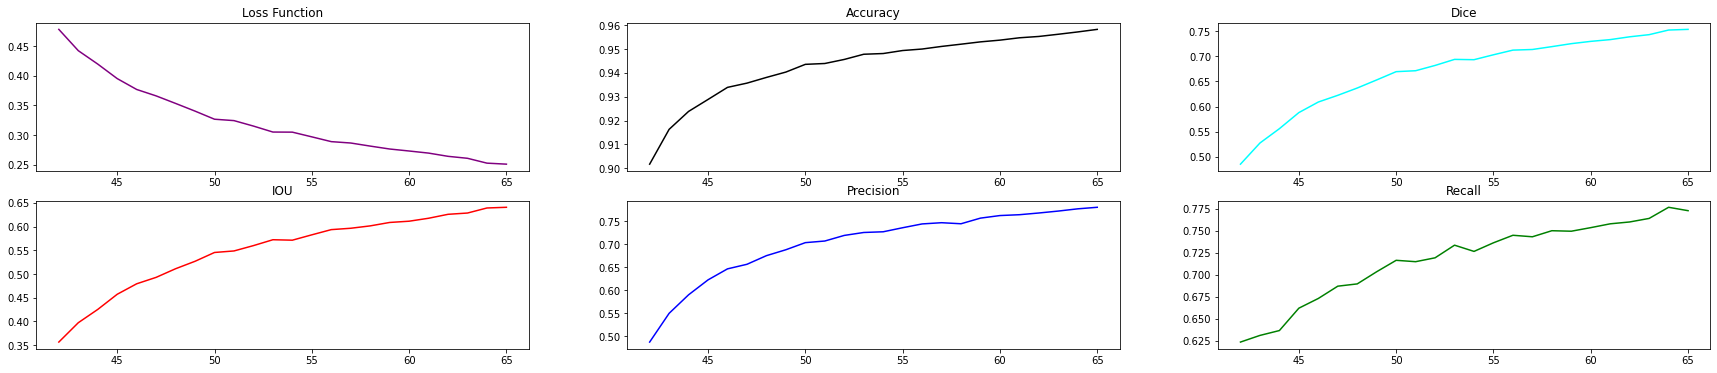

Test plots:


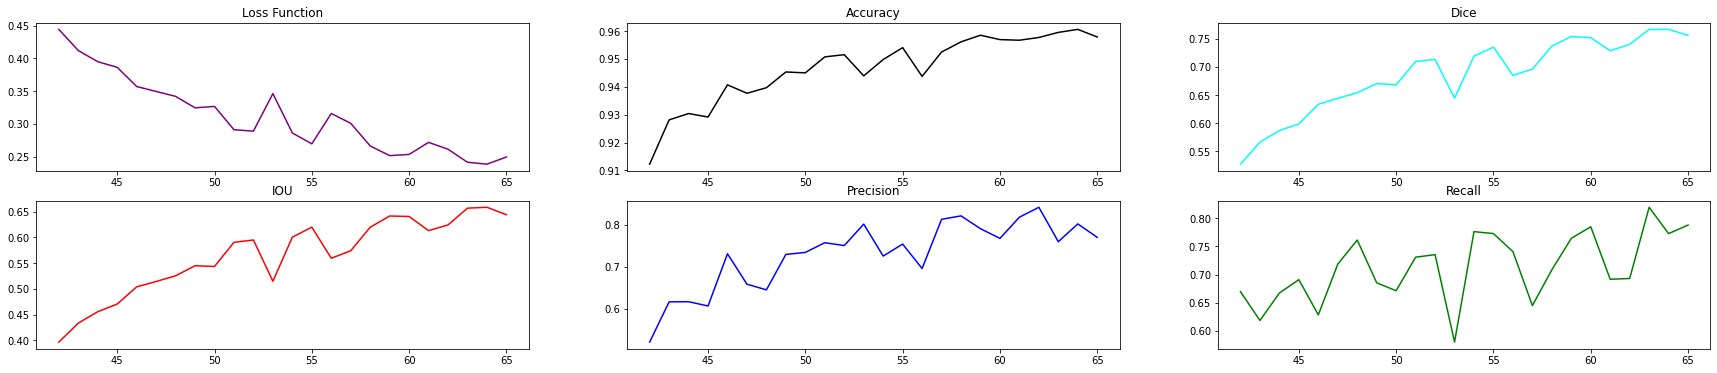

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 66/300


train_loss: 0.25003818391170696
train_accuracy: 0.9588245489658453
train_sensitivity: 0.7759505699119179
train_dice: 0.7551342788606118
train_precision 0.7819938012641844
train_recall 0.7759505699119179
IOU: 0.6414438521028104
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9595757229424222
Test Sensitivity :  0.7967509175394918
Test Pecision :  0.777991941123655
Test Recall :  0.7967509175394918
Test loss :  0.24055204286680118
Test IOU :  0.654639890342405
Test Dice :  0.7666455502911802
Train plots:


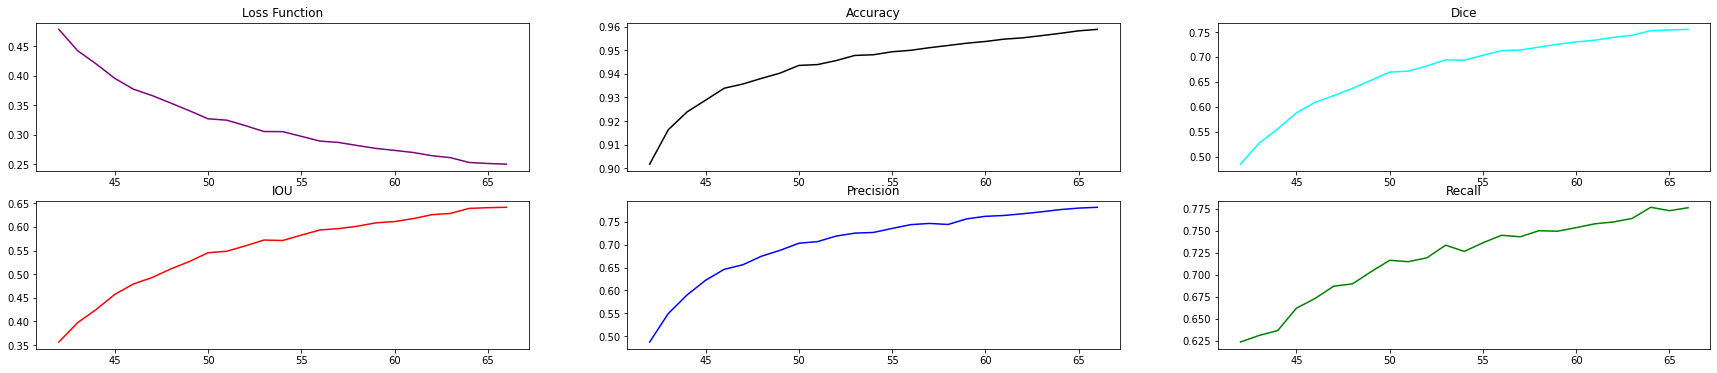

Test plots:


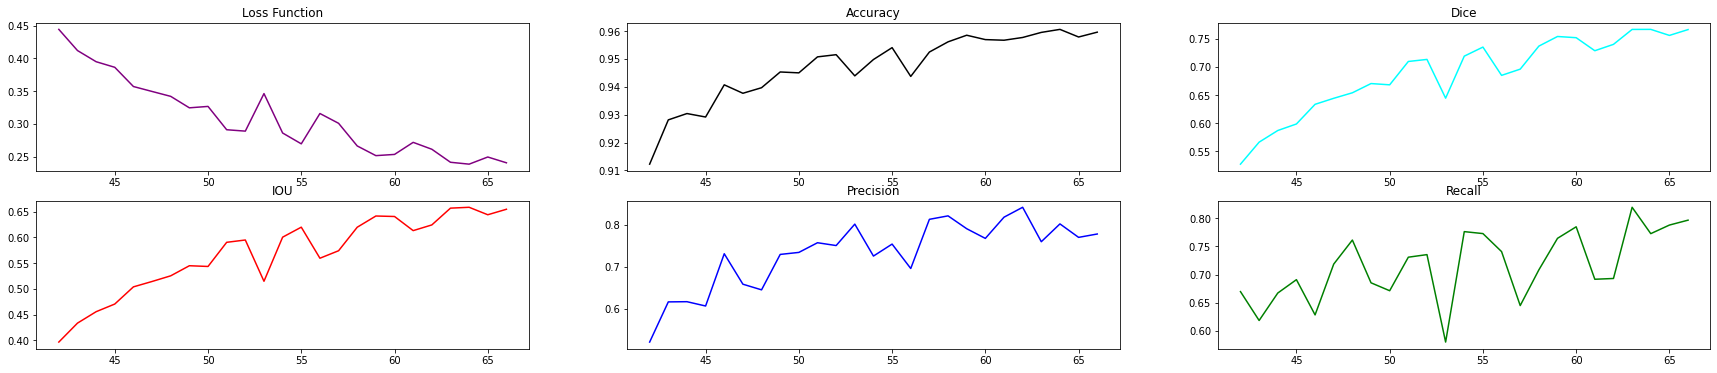

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 67/300


train_loss: 0.24982905232316846
train_accuracy: 0.958091316642342
train_sensitivity: 0.7720239623748244
train_dice: 0.7552240138426559
train_precision 0.7803671313355925
train_recall 0.7720239623748244
IOU: 0.6438539999137606
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.959560072902358
Test Sensitivity :  0.7881317138671875
Test Pecision :  0.788888672769288
Test Recall :  0.7881317138671875
Test loss :  0.23865743783804086
Test IOU :  0.6571680984217605
Test Dice :  0.7687196836366759
Train plots:


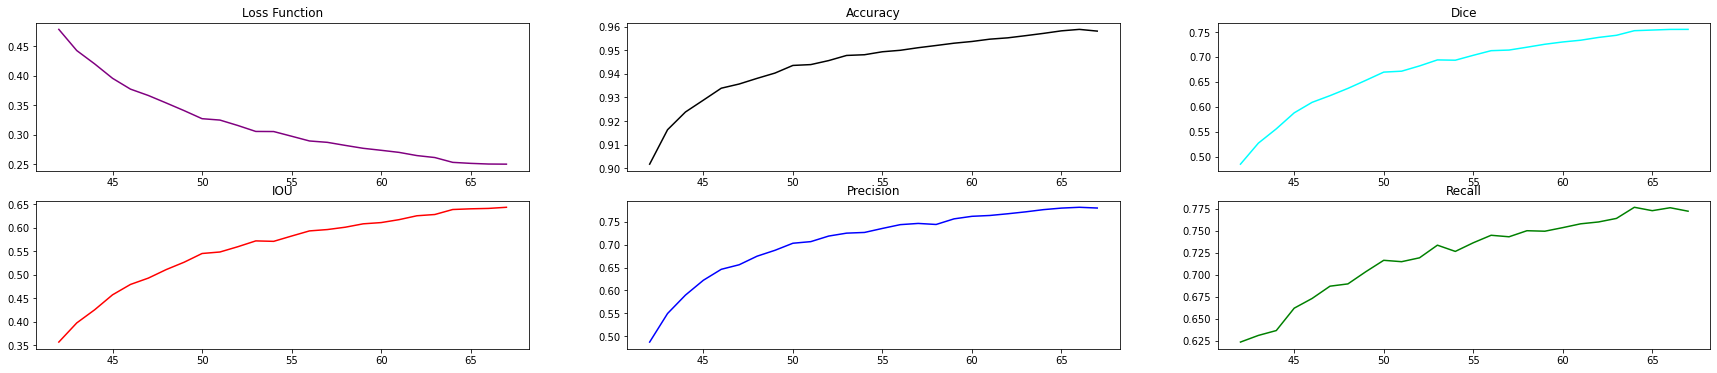

Test plots:


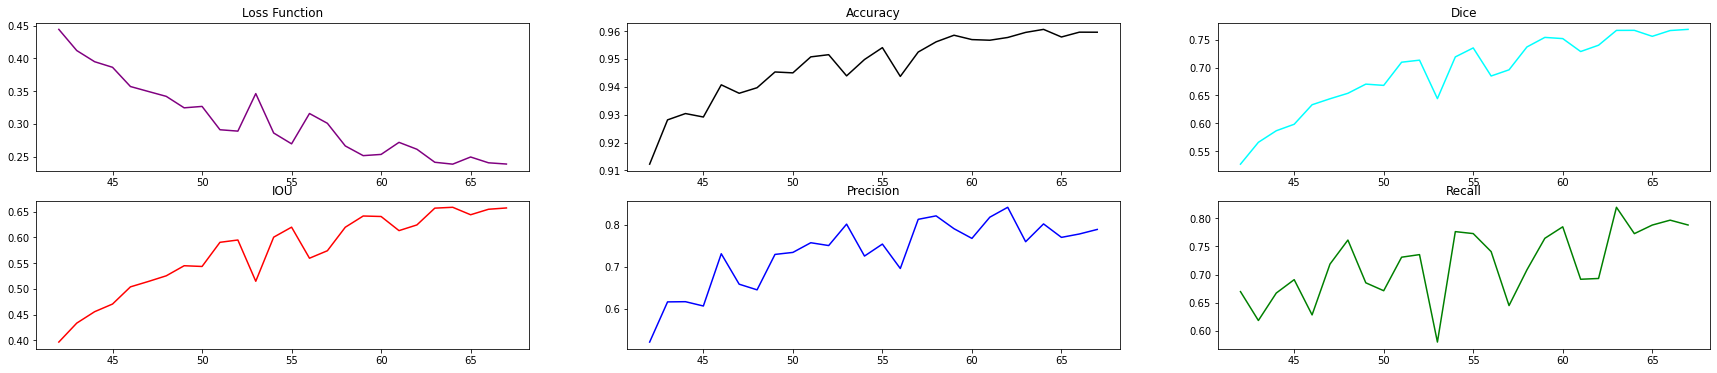

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 68/300


train_loss: 0.2497959246401822
train_accuracy: 0.9579846727979052
train_sensitivity: 0.7761329937617093
train_dice: 0.7549082312192222
train_precision 0.778808056544035
train_recall 0.7761329937617093
IOU: 0.6431120680308229
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9612582140353136
Test Sensitivity :  0.735452393472413
Test Pecision :  0.8454468555939503
Test Recall :  0.735452393472413
Test loss :  0.23512200994805976
Test IOU :  0.6609021420880552
Test Dice :  0.7691846575055804
Train plots:


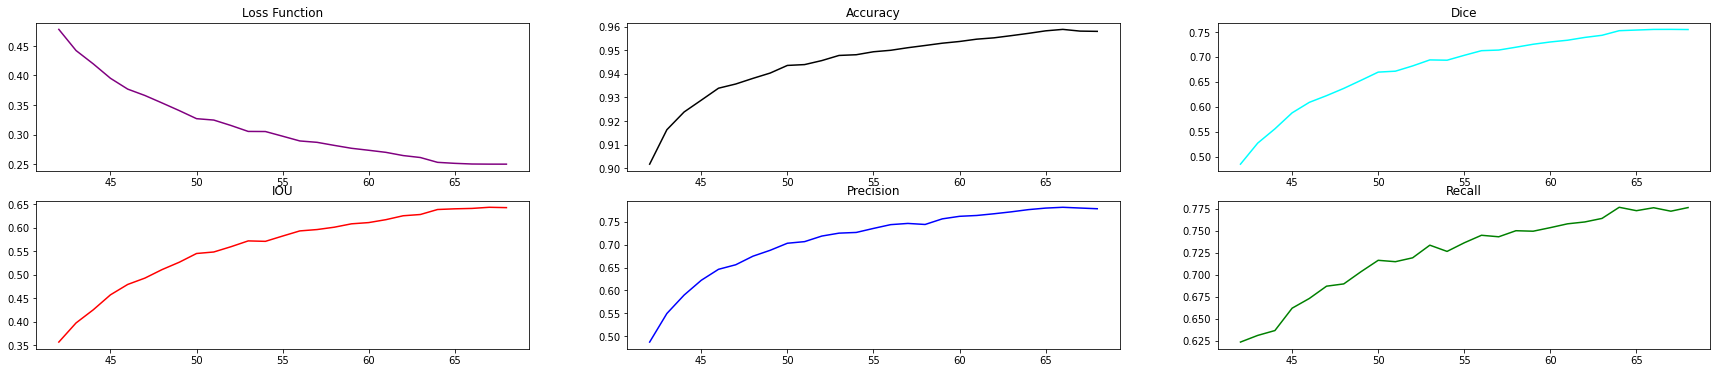

Test plots:


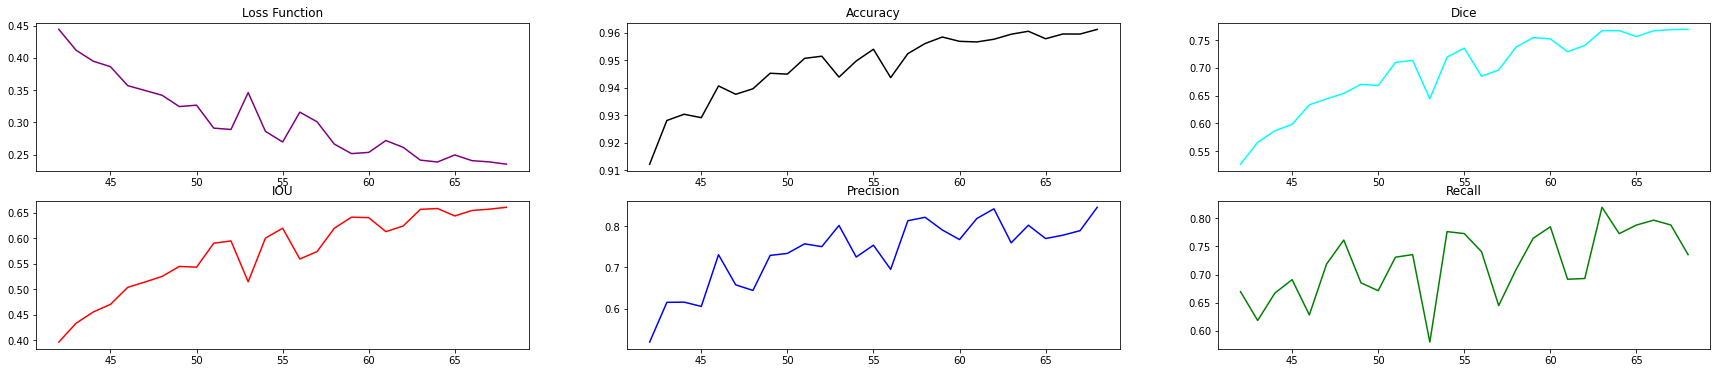

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 69/300


train_loss: 0.2470035471240461
train_accuracy: 0.9578744238549537
train_sensitivity: 0.7751373961668516
train_dice: 0.7580247255768832
train_precision 0.7840604533883999
train_recall 0.7751373961668516
IOU: 0.6455236262377034
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9628996796660371
Test Sensitivity :  0.7771463918161916
Test Pecision :  0.8178851787860577
Test Recall :  0.7771463918161916
Test loss :  0.22546970800602392
Test IOU :  0.6724874196035084
Test Dice :  0.780853774521377
Train plots:


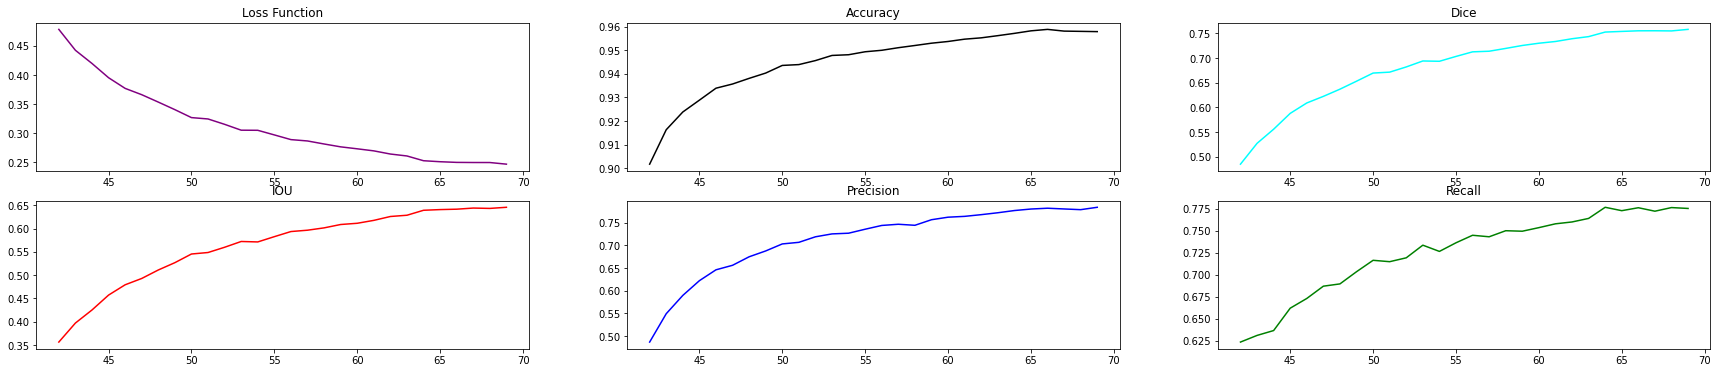

Test plots:


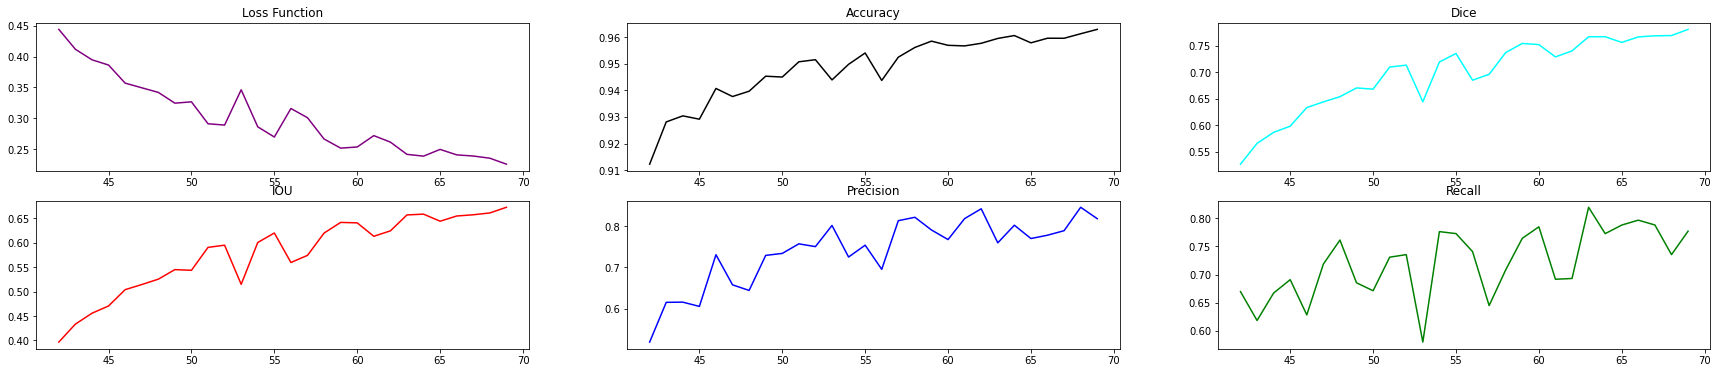

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 70/300


train_loss: 0.2439602573262357
train_accuracy: 0.9591265667925825
train_sensitivity: 0.7796954198291819
train_dice: 0.7613517956416107
train_precision 0.7891322410712199
train_recall 0.7796954198291819
IOU: 0.6493731568623797
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9631785857371795
Test Sensitivity :  0.8183092389787946
Test Pecision :  0.7950374617244734
Test Recall :  0.8183092389787946
Test loss :  0.21930403936476933
Test IOU :  0.6848342392470811
Test Dice :  0.7885753366100046
Train plots:


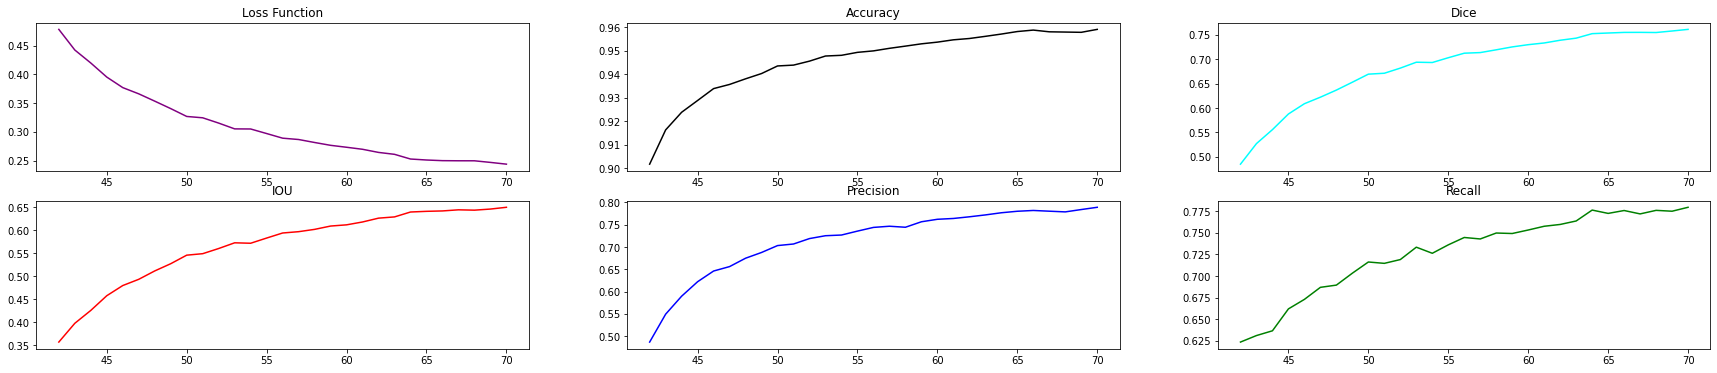

Test plots:


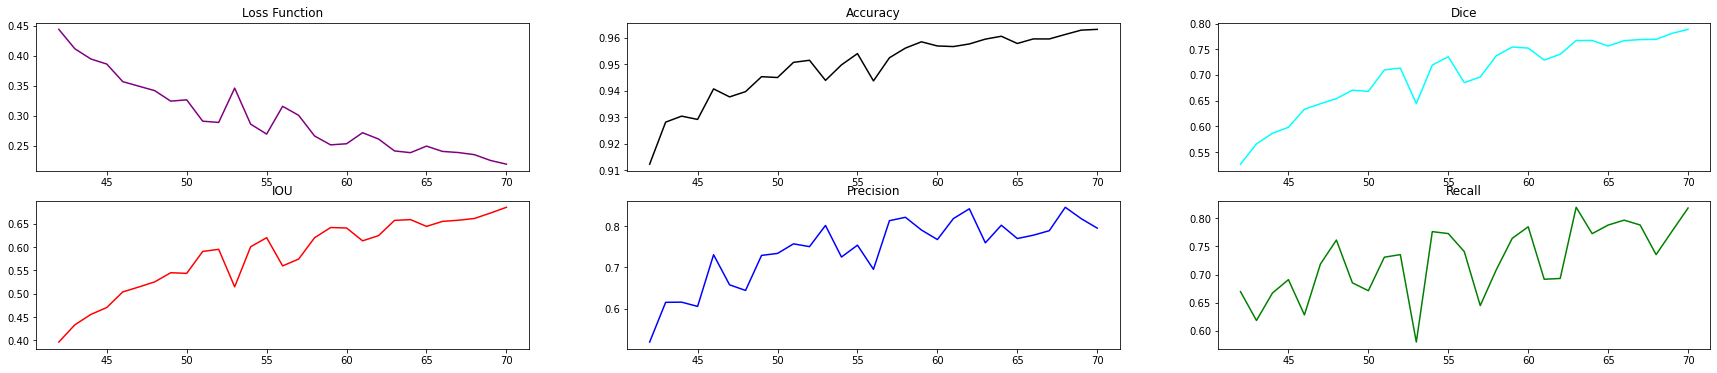

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 71/300


train_loss: 0.23627544330235148
train_accuracy: 0.9604881761711596
train_sensitivity: 0.7858923199281034
train_dice: 0.7699771060940089
train_precision 0.7952051925278997
train_recall 0.7858923199281034
IOU: 0.6611082427352213
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9637706043956044
Test Sensitivity :  0.8286259130680518
Test Pecision :  0.7935899448045444
Test Recall :  0.8286259130680518
Test loss :  0.21564649924253806
Test IOU :  0.6889896043491014
Test Dice :  0.7925909133184523
Train plots:


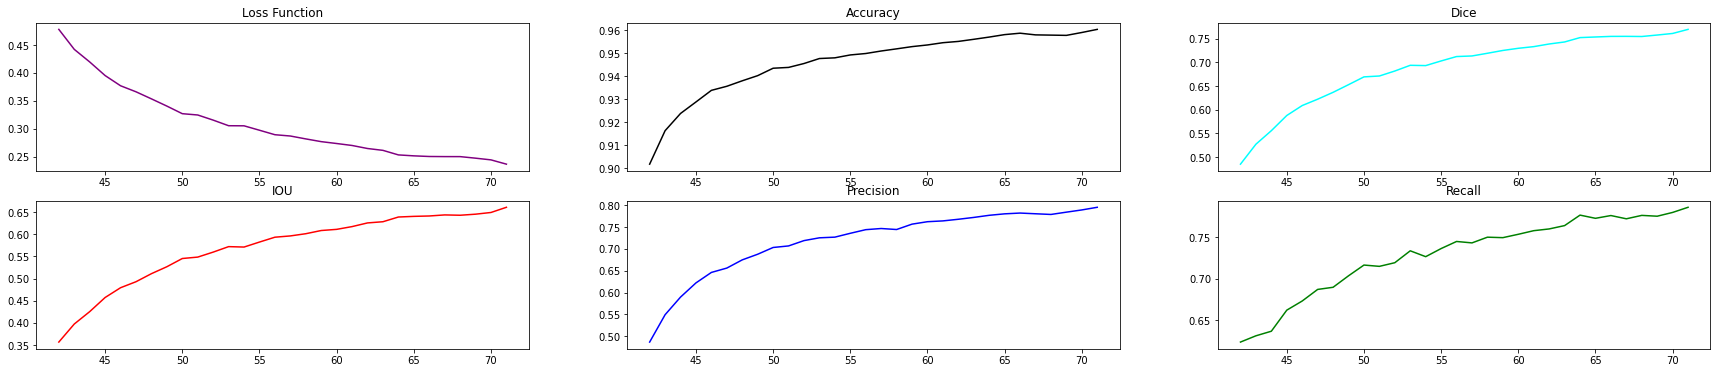

Test plots:


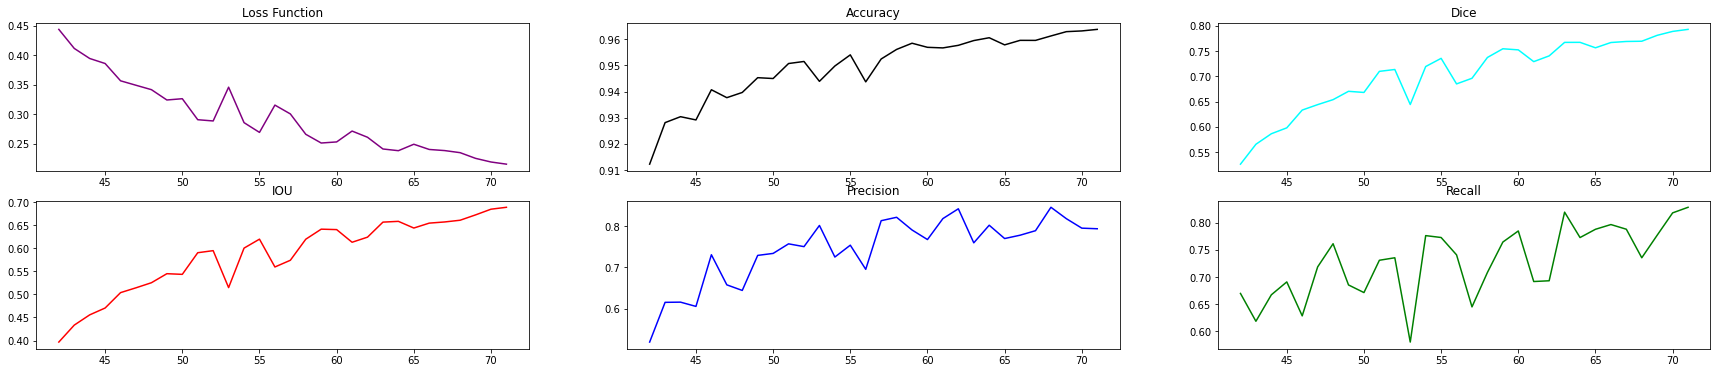

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 72/300


train_loss: 0.23368259482495077
train_accuracy: 0.9607476873712225
train_sensitivity: 0.789237499003377
train_dice: 0.7734318595403471
train_precision 0.798654147515273
train_recall 0.789237499003377
IOU: 0.6643690000473259
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9613876622238439
Test Sensitivity :  0.8002906212439904
Test Pecision :  0.8131744608337625
Test Recall :  0.8002906212439904
Test loss :  0.2231345962692093
Test IOU :  0.6809409564231341
Test Dice :  0.7880220518007384
Train plots:


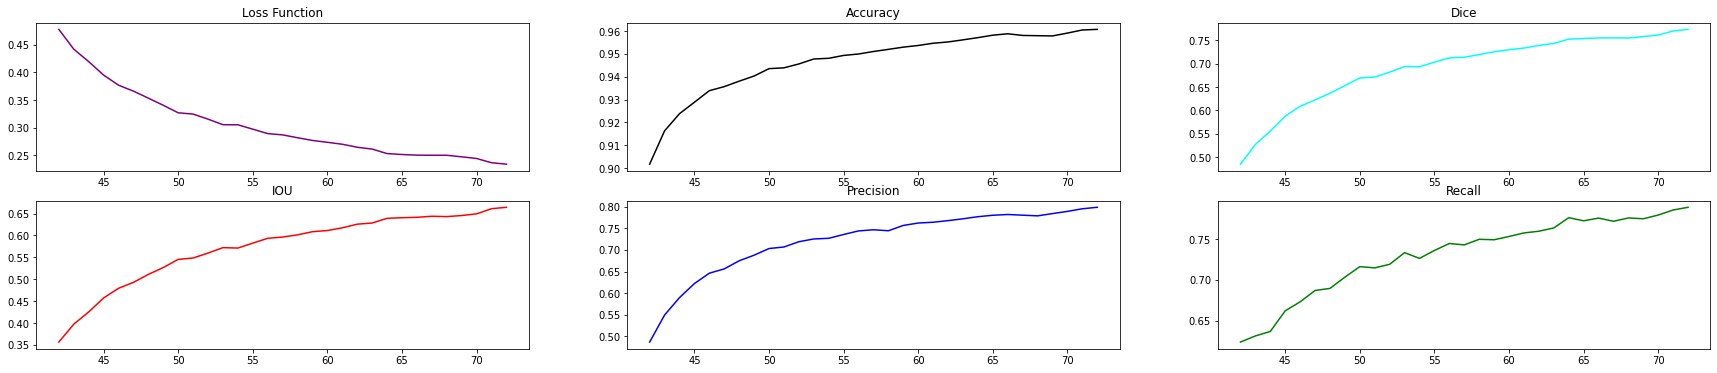

Test plots:


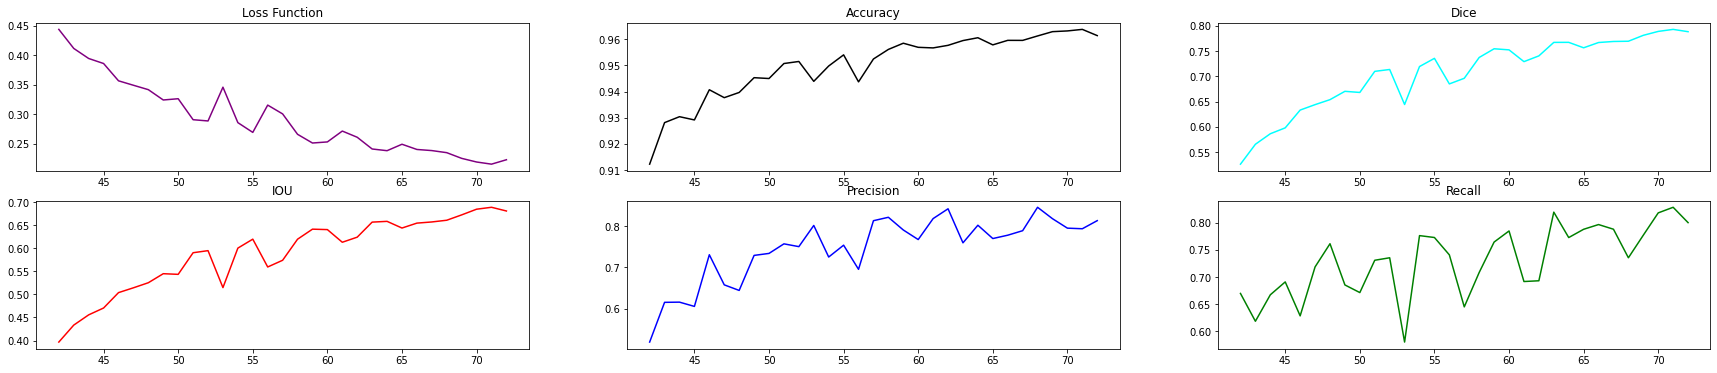

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 73/300


train_loss: 0.231918441848113
train_accuracy: 0.9609681573106256
train_sensitivity: 0.7887663280245107
train_dice: 0.7763986110618174
train_precision 0.8031791168789126
train_recall 0.7887663280245107
IOU: 0.6674349408966895
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9623018481355884
Test Sensitivity :  0.8406168619791666
Test Pecision :  0.7731907882969895
Test Recall :  0.8406168619791666
Test loss :  0.21955618666205215
Test IOU :  0.6840706290779534
Test Dice :  0.7877833886897607
Train plots:


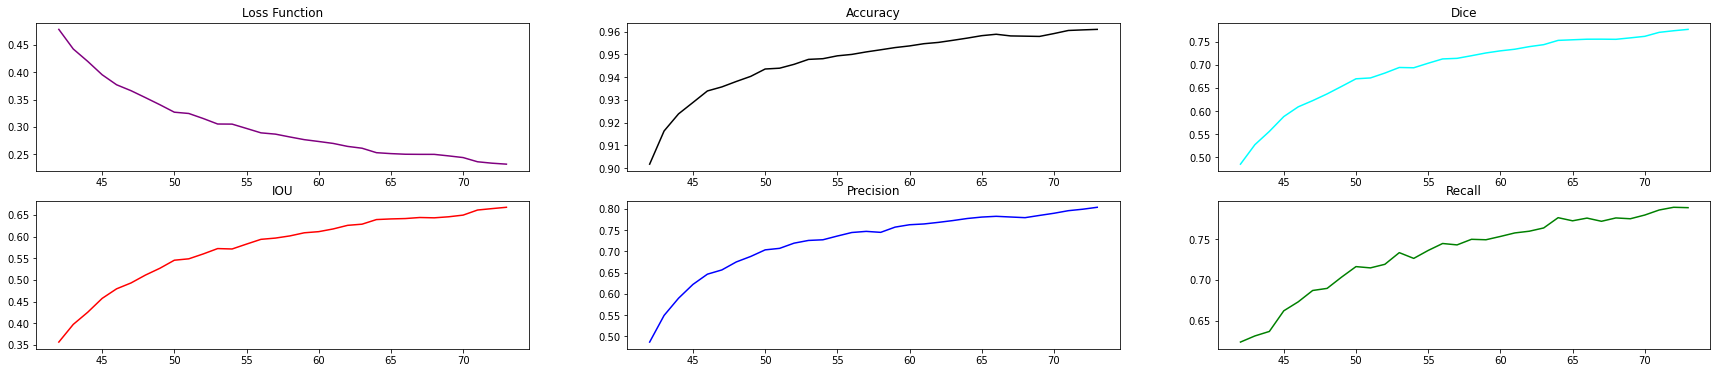

Test plots:


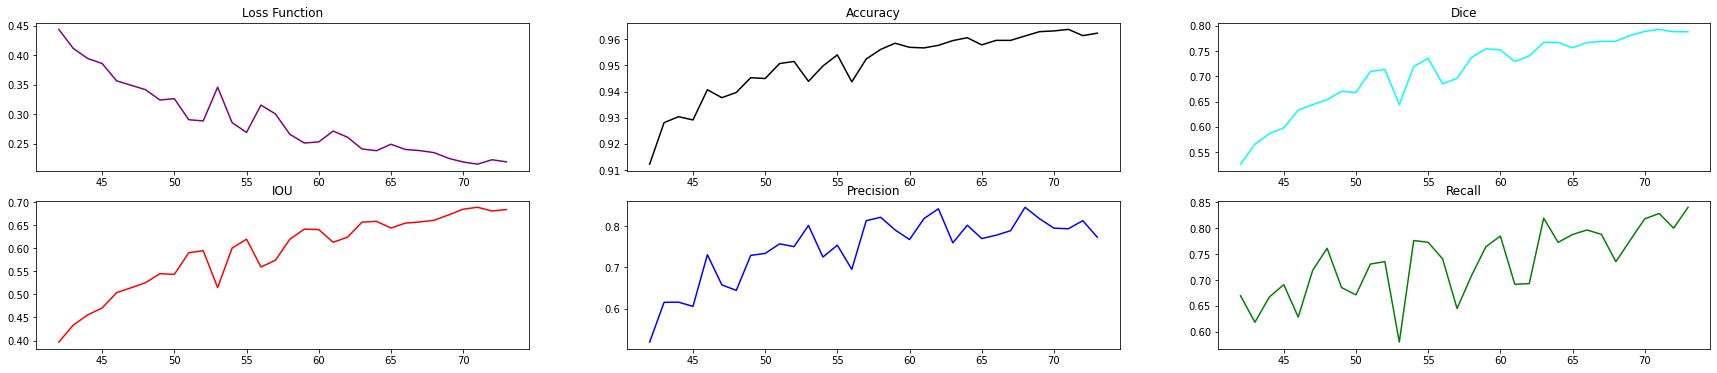

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 74/300


train_loss: 0.23440447148795313
train_accuracy: 0.9607351952856713
train_sensitivity: 0.7926132828730666
train_dice: 0.7725572121933431
train_precision 0.7943702580798724
train_recall 0.7926132828730666
IOU: 0.662853485959217
Learning rate:  0.0002
---------------------------------------------
Test Accuracy :  0.9597262986850389
Test Sensitivity :  0.7176434862744677
Test Pecision :  0.8594165843921703
Test Recall :  0.7176434862744677
Test loss :  0.24192033145890568
Test IOU :  0.6526455163082361
Test Dice :  0.7649623884822859
Train plots:


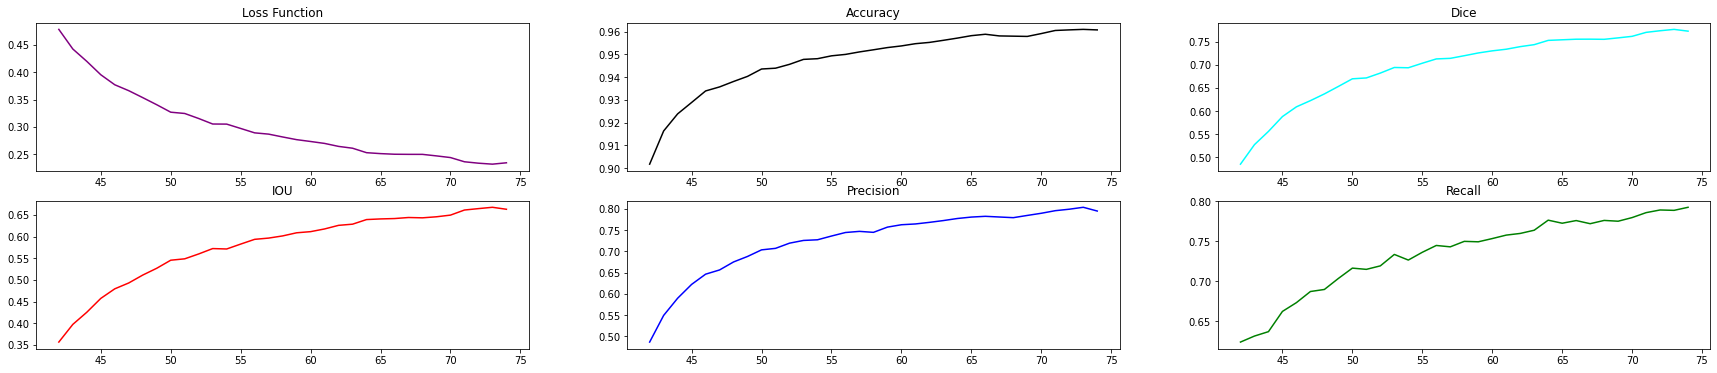

Test plots:


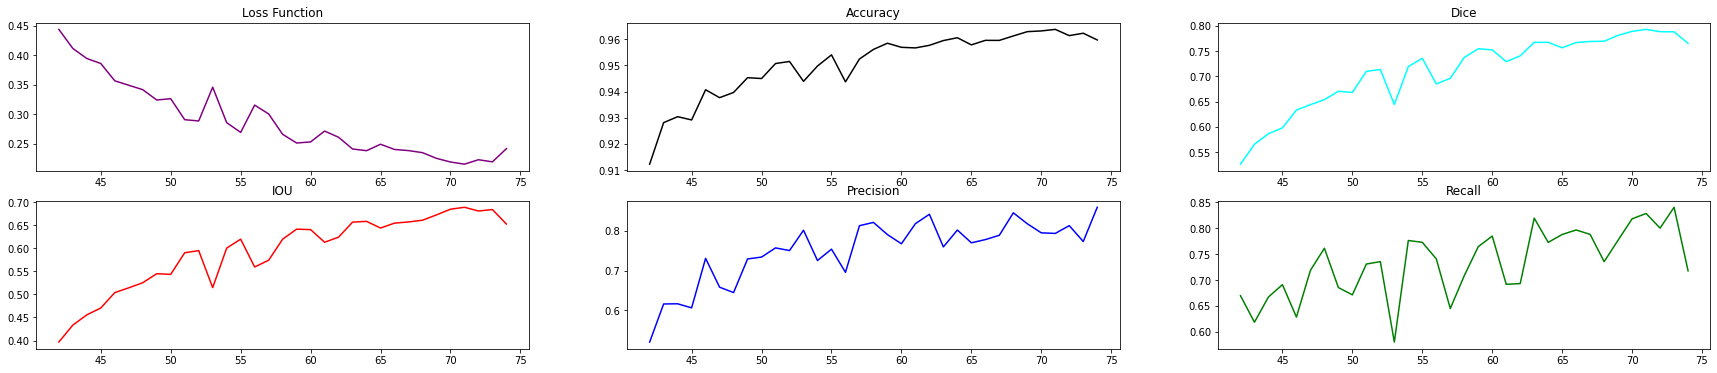

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Epoch 75/300


In [ ]:
def trainer_chan(epoch, epochs, train_loader, solver, logfile):
    keep_training = True
    no_optim = 0
    train_epoch_best_loss = INITAL_EPOCH_LOSS
    prev_loss = 1
    print('Epoch {}/{}'.format(epoch, epochs))
    train_epoch_loss = 0
    train_epoch_dice = 0
    train_epoch_acc = 0
    train_epoch_sen = 0
    train_epoch_pre = 0
    train_epoch_rec = 0
    train_epoch_iou = 0
    p_loss = 10

    # index = 0
    length = len(train_loader)
    iterator = tqdm(enumerate(train_loader), total=length, leave=False, desc=f'Epoch {epoch}/{epochs}')
    for index, (img, mask) in iterator :

        img = img.to(device)
        mask = mask.to(device)
        #print(mask.shape)
        solver.set_input(img, mask)
        train_loss, pred = solver.optimize()
        #print(pred.shape, mask.shape)
        train_acc, train_sen, train_iou = acc_sen_iou(pred,mask)
        train_dice = dice_score(mask, pred)
        train_pre, train_rec = calc_prerec(mask, pred)

        train_loss = train_loss.detach().cpu().numpy()
        train_acc = train_acc.detach().cpu().numpy()
        train_sen = train_sen.detach().cpu().numpy()
        train_dice = train_dice.detach().cpu().numpy()
        train_pre = train_pre.detach().cpu().numpy()
        train_rec = train_rec.detach().cpu().numpy()
        train_iou = train_iou.detach().cpu().numpy()

        train_epoch_loss += train_loss
        train_epoch_acc += train_acc
        train_epoch_sen += train_sen
        train_epoch_dice += train_dice
        train_epoch_pre += train_pre
        train_epoch_rec += train_rec
        train_epoch_iou += train_iou

        # index = index + 1
        # print(index, end = ' ')

    train_epoch_loss = train_epoch_loss/len(train_dataset)
    train_epoch_acc = train_epoch_acc/len(train_dataset)
    train_epoch_sen = train_epoch_sen/len(train_dataset)
    train_epoch_dice = train_epoch_dice/len(train_dataset)
    train_epoch_pre = train_epoch_pre/len(train_dataset)
    train_epoch_rec = train_epoch_rec/len(train_dataset)
    train_epoch_iou = train_epoch_iou/len(train_dataset)

    print('train_loss:', train_epoch_loss)
    print('train_accuracy:', train_epoch_acc)
    print('train_sensitivity:', train_epoch_sen)
    print('train_dice:', train_epoch_dice)
    print('train_precision', train_epoch_pre)
    print('train_recall', train_epoch_rec)
    print('IOU:', train_epoch_iou)
    print('Learning rate: ', solver.lr)

    logfile.write('Epoch: '+str(epoch)+'/'+str(epochs)+'\n')
    logfile.write('train_loss: '+str(train_epoch_loss)+'\n')
    logfile.write('train_accuracy: '+str(train_epoch_acc)+'\n')
    logfile.write('train_sensitivity: '+str(train_epoch_sen)+'\n')
    logfile.write('train_dice: '+str(train_epoch_dice)+'\n')
    logfile.write('train_precision: '+str(train_epoch_pre)+'\n')
    logfile.write('train_recall: '+str(train_epoch_rec)+'\n')
    logfile.write('train_iou: '+str(train_epoch_iou)+'\n')
    logfile.write('Learning rate: '+str(solver.lr)+'\n')


    if train_epoch_loss >= train_epoch_best_loss:
        no_optim += 1
        prev_loss = train_epoch_loss
    else:
        no_optim = 0
        #train_epoch_best_loss = train_epoch_loss
        prev_loss = train_epoch_loss
        if train_epoch_loss < train_epoch_best_loss:
            solver.save('/content/drive/MyDrive/Saved Models/CVC_UT_hritam_300.pth')
            train_epoch_best_loss = train_epoch_loss

    if no_optim > NUM_UPDATE_LR:
        if solver.lr < 1e-9: keep_training=False
        solver.load('/content/drive/MyDrive/Saved Models/CVC_UT_hritam_300.pth')
        solver.update_lr(5, factor=True)
        no_optim = 0



    if no_optim > NUM_EARLY_STOP:
        print('early stop at %d epoch' % epoch)
        print('early stop at %d epoch' % epoch)
        keep_training = False


    print('---------------------------------------------')
    return train_epoch_loss, train_epoch_acc, train_epoch_sen, train_epoch_pre, train_epoch_rec, train_epoch_dice, train_epoch_iou, keep_training

def tester_chan(model,test_loader, logfile):
    test_acc = 0
    test_sen = 0
    test_prec= 0
    test_recc= 0
    dsc1 = 0
    test_iou = 0
    test_loss = 0
    test_dice = 0
    Loss_console = horny_loss()
    with torch.no_grad() :
        it = 0
        for index, (img, mask) in enumerate(test_loader) :
            it+=1
            img = img.to(device)
            mask = mask.to(device)
            pred = model.forward(img)

            #index = pred.cpu().numpy()
            #os.path.join(image_root, image_name.split('.')[0] + '.png')
            #torch.save(pred,os.path.join(output,image_name.split('.')[0]+'.png'))

            #
            acc, sen, iou = acc_sen_iou(pred, mask)
            prec,recc = calc_prerec(mask,pred)
            loss = Loss_console.forward(mask, pred)
            dsc= dice_score(mask,pred)
            '''
            if (dsc>=0.8):
            dsc1 += dsc
            count+=1
            '''
            test_acc += acc
            test_sen += sen
            test_prec += prec
            test_recc += recc
            test_iou += iou
            test_loss += loss
            test_dice += dsc

            # print(index, end = ' ')

        test_acc = test_acc.detach().cpu().numpy()
        test_sen = test_sen.detach().cpu().numpy()
        test_prec = test_prec.detach().cpu().numpy()
        test_recc = test_recc.detach().cpu().numpy()
        test_iou = test_iou.detach().cpu().numpy()
        test_loss = test_loss.detach().cpu().numpy()
        test_dice = test_dice.detach().cpu().numpy()

        test_acc = test_acc / len(test_dataset)
        test_sen = test_sen / len(test_dataset)
        test_prec = test_prec/len(test_dataset)
        test_iou = test_iou/len(test_dataset)
        test_recc = test_recc/len(test_dataset)
        test_loss = test_loss/len(test_dataset)
        test_dice = test_dice/len(test_dataset)


        print('Test Accuracy : ', test_acc)
        print('Test Sensitivity : ', test_sen)
        print('Test Pecision : ', test_prec)
        print('Test Recall : ', test_recc)
        print('Test loss : ', test_loss)
        print('Test IOU : ', test_iou)
        print('Test Dice : ', test_dice)

        logfile.write('----------------------------------------------------------\n')
        logfile.write('test_loss: '+str(test_loss)+'\n')
        logfile.write('test_accuracy: '+str(test_acc)+'\n')
        logfile.write('test_sensitivity: '+str(test_sen)+'\n')
        logfile.write('test_dice: '+str(test_dice)+'\n')
        logfile.write('test_precision: '+str(test_prec)+'\n')
        logfile.write('test_recall: '+str(test_recc)+'\n')
        logfile.write('test_iou: '+str(test_iou)+'\n')
        logfile.write('----------------------------------------------------------\n')
        logfile.write('----------------------------------------------------------\n')
        logfile.write('----------------------------------------------------------\n')
        logfile.close()

        return test_loss, test_acc, test_sen, test_prec, test_recc, test_dice, test_iou

solver = MyFrame(UTNet, learning_rate, device)
solver.load('/content/drive/MyDrive/Saved Models/CVC_UT_hritam_300.pth')

tr_Loss = []
tr_Accuracy = []
tr_Sensitivity = []
tr_Dice = []
tr_IOU = []
tr_Precision = []
tr_Recall = []
tr_LR = []

EP = []

te_Loss = []
te_Accuracy = []
te_Sensitivity = []
te_Dice = []
te_IOU = []
te_Precision = []
te_Recall = []
te_LR = []
'''
v = open('/content/drive/MyDrive/Log/Variables/cvc_hritam.pkl', 'rb')
tr_Loss, tr_Accuracy, tr_Sensitivity, tr_Dice, tr_IOU, tr_Precision, tr_Recall, EP = pickle.load(v)
v = open('/content/drive/MyDrive/Log/Variables/cvc_hritam.pkl', 'rb')
te_Loss, te_Accuracy, te_Sensitivity, te_Dice, te_IOU, te_Precision, te_Recall = pickle.load(v)
'''
logfile = open('/content/drive/MyDrive/Log/cvc_hritam.txt', 'w')
logfile.write('Training.cvc_hritam \n')
logfile.close()
for epoch in range(42, epochs + 1):
    logfile = open('/content/drive/MyDrive/Log/cvc_hritam.txt', 'a')

    l,a,s,p,r,d,i,k = trainer_chan(epoch, epochs, train_loader, solver, logfile)
    tr_Loss += [l]
    tr_Accuracy += [a]
    tr_Sensitivity += [s]
    tr_Dice += [d]
    tr_IOU += [i]
    tr_Precision += [p]
    tr_Recall += [r]
    EP += [epoch]

    tr_comp = [tr_Loss, tr_Accuracy, tr_Sensitivity, tr_Dice, tr_IOU, tr_Precision, tr_Recall, EP]

    lt,at,st,pt,rt,dt,it = tester_chan(solver.net, test_loader, logfile)
    te_Loss += [lt]
    te_Accuracy += [at]
    te_Sensitivity += [st]
    te_Dice += [dt]
    te_IOU += [it]
    te_Precision += [pt]
    te_Recall += [rt]

    te_comp = [te_Loss, te_Accuracy, te_Sensitivity, te_Dice, te_IOU, te_Precision, te_Recall]

    var1 = open('/content/drive/MyDrive/Log/Variables/cvc_hritam.pkl', 'wb')
    var2 = open('/content/drive/MyDrive/Log/Variables/cvc_hritam.pkl', 'wb')
    pickle.dump(tr_comp, var1)
    pickle.dump(te_comp, var2)
    var1.close()
    var2.close()

    print('Train plots:')
    visualise(tr_Loss, tr_Accuracy, tr_Dice, tr_IOU, tr_Precision, tr_Recall, EP)
    print('Test plots:')
    visualise(te_Loss, te_Accuracy, te_Dice, te_IOU, te_Precision, te_Recall, EP)
    print('----------------------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------------------')

    if k: continue
    else: break



